In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.rcdefaults()

%matplotlib inline

/home/xwj/soft/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing dataset one by one

In [4]:
# the gene id mapping file is 60000 rows
# input="/media/eys/public_data/ngs/GRCh37/gencode.v19.genes.gtf.ensgids"
input="/media/eys/xwj/proteome/gencode.v22.annotation.gene.probeMap"
ensg2genesymbol=pd.read_csv(input, sep="\t", header=0, low_memory=False)
ensg2genesymbol 

,id,gene,chrom,chromStart,chromEnd,strand
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,+
1,ENSG00000227232.5,WASH7P,chr1,14404,29570,-
2,ENSG00000278267.1,MIR6859-3,chr1,17369,17436,-
3,ENSG00000243485.3,RP11-34P13.3,chr1,29554,31109,+
4,ENSG00000274890.1,MIR1302-9,chr1,30366,30503,+
...,...,...,...,...,...,...
60478,ENSG00000198695.2,MT-ND6,chrM,14149,14673,-
60479,ENSG00000210194.1,MT-TE,chrM,14674,14742,-
60480,ENSG00000198727.2,MT-CYB,chrM,14747,15887,+
60481,ENSG00000210195.2,MT-TT,chrM,15888,15953,+


In [ ]:
input="/media/eys/xwj/proteome/Excel_error_genesymbol_mapping.txt"
excel_error_genesymbol_mapping = pd.read_csv(input, sep="\t", header=0, low_memory=False, index_col=None).set_index("Wrong")

In [10]:
# the gene id mapping file is +43000 rows
input="/media/eys/xwj/proteome/hgnc_complete_set.txt"
hgnc=pd.read_csv(input, sep="\t", header=0, low_memory=False)
hgnc=hgnc[(hgnc.status == "Approved")]
hgnc=hgnc[~(pd.isna(hgnc.ensembl_gene_id) | (hgnc.ensembl_gene_id == ""))]

In [1377]:
## list of proteins in any known complex
input="/media/eys/xwj/proteome/coreComplexesFromCORUM.txt"
corum=pd.read_csv(input, sep="\t", header=0, low_memory=False)
temp = ([x.split(";") for x in corum.loc[:, "subunits(Entrez IDs)"]])
temp = list(set(np.concatenate(temp)))#.astype(int))
list_protein_in_complex=[]
for x in temp:
    if x == 'None': #
        continue
    list_protein_in_complex.append(np.int(x))
list_protein_in_complex = hgnc.loc[ hgnc.entrez_id.isin(list_protein_in_complex), "ensembl_gene_id"] #.ensembl_gene_id

if False: 
    with open('/media/eys/xwj/proteome/data/20210421_list_protein_in_complex_CORUM.pkl', 'wb') as f:    
        pickle.dump( [list_protein_in_complex],  f)

In [1408]:
inputfile = "/media/eys/xwj/proteome/Zecha2018_protein_halflife_and_more_supp_RA118.000583_134915_1_supp_65961_p3f7xq.xlsx"
zecha_protein_property = pd.read_excel(inputfile, sheet_name="Properties and functions")
zecha_protein_property = zecha_protein_property.set_index("Gene name(s)")#")#Q.loc[:, "Gene name(s)"]

In [1414]:
list_common_symbol = set(hgnc.symbol) & set(zecha_protein_property.index)
zecha_protein_property = zecha_protein_property.loc[list_common_symbol,:]
for s in zecha_protein_property.index:
    zecha_protein_property.loc[s, "ensembl_gene_id"] = hgnc.loc[hgnc.symbol == s, "ensembl_gene_id"].values
zecha_protein_property = zecha_protein_property.set_index("ensembl_gene_id")

In [1419]:
if False: 
    with open('/media/eys/xwj/proteome/data/20210422_zecha_protein_property_ensembl_id.pkl', 'wb') as f:    
        pickle.dump( [zecha_protein_property],  f)

In [9]:
#####symbol 2 ensembl
inputfile = '/media/eys/xwj/proteome/data/20210907ptm.pkl'
with open(inputfile, 'rb') as f:
    [ ptm ]=pickle.load(f)
new_index = symbol2ensembl(ptm)

###########10587


In [13]:
if False: 
    with open('/media/eys/xwj/proteome/data/20210907ptm_ensembl_id.pkl', 'wb') as f:    
        pickle.dump( [new_index],  f)

In [1]:
# mapping protein symbol ensembl
def symbol2ensembl(pm):
    protein_matrix_new_index=pd.DataFrame(index=pm.index, columns=["ensembl_gene_id"])
    count=0
    unknown=pd.isnull(protein_matrix_new_index.ensembl_gene_id)
    for original_symbol in protein_matrix_new_index.index[unknown]:
        # 如果在hgnc中有，ok；否则，用hgnc table 来查询symbol的别名，从而找到ENSG id
        if count%1000==1:
            print("#", end="", flush=True)
        for symbol in original_symbol.split(";"):
            mask_in_hgnc = hgnc.symbol == symbol
            if any(mask_in_hgnc):
                count+=1
                protein_matrix_new_index.loc[original_symbol]=hgnc.ensembl_gene_id[mask_in_hgnc].values
                break # break symbol for loop
            else:
                success=False
                for (hgnc_symbol, alias, prevs, ensgid) in \
                zip(hgnc.symbol, hgnc.alias_symbol, hgnc.prev_symbol, hgnc.ensembl_gene_id):
                    if (symbol.lower() == hgnc_symbol.lower()):
                        success=True
                        break
                    # if previous symbol is matched, use
                    elif (symbol.lower() in str(prevs).lower().split(sep="|")):
        #                     print(symbol,str(alias), str(prevs), ensgid)
                        success=True
                        break
                    elif (symbol.lower() in str(alias).lower().split(sep="|")):
        #                     print(symbol,str(alias), str(prevs), ensgid)
                        success=True
                        break
                    else:
                        pass
                if success:
                    count+=1
                    protein_matrix_new_index.loc[original_symbol]=ensgid
                    break # break symbol for loop
    print(count)
    return protein_matrix_new_index


## colon 86
log2 transformation of spectral count
mean(spectral count) > 1.4

```shell
cat CPTACsampleID_TCGAparticipantID_mapping.txt | sed 's/-[0-9][0-9]\t/\t/' | cut -f1 | paste - CPTACsampleID_TCGAparticipantID_mapping.txt > shortid_CPTACsampleID_TCGAparticipantID_mapping.txt

cut -f1 shortid_CPTACsampleID_TCGAparticipantID_mapping.txt | tail -n +2 > TCGA.shortid.87.id

head -n1 TCGA-COAD.htseq_counts.tsv | tr '\t' '\n' | grep -f TCGA.shortid.87.id  > TCGA.common.id
head -n1 TCGA-READ.htseq_counts.tsv | tr '\t' '\n' | grep -f TCGA.shortid.87.id  >> TCGA.common.id
```

In [1111]:
# a list of common samples of protein and mRNA experiments
input="/media/eys/xwj/proteome/data/colon/TCGA.common.86.id"
common_id_list=[line.strip() for line in open(input, 'r')]
# ['TCGA-AA-3529-01A',
#  'TCGA-AA-3848-01A', .... ]

# start from raw id mapping file
input="/media/eys/xwj/proteome/data/colon/shortid_CPTACsampleID_TCGAparticipantID_mapping.txt"
id_mapping=pd.read_csv(input, sep="\t", low_memory=False, header=0,index_col=0)

# raw matrix
input="/media/eys/xwj/proteome/data/colon/protein_raw95.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

# take columns of common samples
protein_matrix=protein_raw.loc[:, id_mapping.loc[common_id_list, "CPTACsampleID"]].round(3)

# output="/media/eys/xwj/proteome/data/colon/protein_matrix_7211row86col.txt"
# protein_matrix.to_csv(output, sep="\t", index=True, header=True)
del protein_raw
protein_matrix.head()

,TCGA-AA-3529-01A-12,TCGA-AA-3848-01A-22,TCGA-AA-3818-01A-22,TCGA-AA-3710-01A-22,TCGA-AA-A00N-01A-32,TCGA-AA-3715-01A-22,TCGA-AA-A00R-01A-22,TCGA-AA-3672-01A-22,TCGA-AA-3684-01A-31,TCGA-AA-3989-01A-22,...,TCGA-AG-4007-01A-22,TCGA-AG-A016-01A-23,TCGA-AG-A008-01A-23,TCGA-AG-A015-01A-51,TCGA-AF-3400-01A-41,TCGA-AG-3580-01A-22,TCGA-AG-A00Y-01A-12,TCGA-AG-A032-01A-31,TCGA-AG-A002-01A-23,TCGA-AF-2692-01A-41
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
A1BG,3.250,3.067,4.080,2.078,6.098,4.196,4.481,2.770,3.996,2.092,...,0.000,1.692,3.874,3.276,5.670,4.121,3.649,2.515,3.465,4.081
A1CF,0.000,0.549,0.000,0.822,0.015,0.030,0.000,0.000,1.678,1.766,...,1.015,1.008,1.570,2.023,1.288,1.595,1.502,1.144,0.000,1.144
A2M,6.177,6.942,6.647,6.705,7.684,6.890,6.787,6.266,6.680,5.566,...,5.858,5.300,6.709,5.485,7.866,5.932,6.399,6.575,7.398,6.830
A2ML1,1.783,1.595,2.056,1.752,3.078,3.847,1.977,1.512,2.367,0.856,...,1.015,1.008,1.954,1.692,2.763,1.595,1.766,1.766,1.697,1.595
AAAS,2.120,1.918,2.056,2.325,0.015,1.894,0.992,2.271,1.030,2.092,...,1.697,2.562,2.552,1.692,2.427,3.006,1.015,1.766,2.195,1.595


In [1114]:
protein_matrix_new_index=pd.DataFrame(index=protein_matrix.index, columns=["ensembl_gene_id"])

In [1115]:
%%time
count=0
for symbol in protein_matrix_new_index.index:
    # 查看TCGA官方i的表能否查到ensg id
    mask= ensg2genesymbol.gene == symbol
    if sum(mask) == 1:
        # 如果ensg id 唯一
        count+=1
        protein_matrix_new_index.loc[symbol]=ensg2genesymbol.id[mask].values
    else:
        # 如果在hgnc中有，ok；否则，用hgnc table 来查询symbol的别名，从而找到ENSG id
        mask_in_hgnc = hgnc.symbol == symbol
        if any(mask_in_hgnc):
            count+=1
            protein_matrix_new_index.loc[symbol]=hgnc.symbol[mask_in_hgnc]
        else:
            success=False
            for (alias, prevs, ensgid) in \
            zip(hgnc.alias_symbol, hgnc.prev_symbol, hgnc.ensembl_gene_id):
                # if previous symbol is matched, use
                if (symbol in str(prevs).split(sep="|")):
#                     print(symbol,str(alias), str(prevs), ensgid)
                    success=True
                    break
                elif (symbol in str(alias).split(sep="|")):
#                     print(symbol,str(alias), str(prevs), ensgid)
                    success=True
                    break
                else:
                    pass
            if success:
                count+=1
                protein_matrix_new_index.loc[symbol]=ensgid
        
print(count)

7195
CPU times: user 45.5 s, sys: 53.9 ms, total: 45.5 s
Wall time: 45.5 s


In [1116]:
# remove any lines have no ENSG id
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
protein_matrix

,TCGA-AA-3529-01A-12,TCGA-AA-3848-01A-22,TCGA-AA-3818-01A-22,TCGA-AA-3710-01A-22,TCGA-AA-A00N-01A-32,TCGA-AA-3715-01A-22,TCGA-AA-A00R-01A-22,TCGA-AA-3672-01A-22,TCGA-AA-3684-01A-31,TCGA-AA-3989-01A-22,...,TCGA-AG-4007-01A-22,TCGA-AG-A016-01A-23,TCGA-AG-A008-01A-23,TCGA-AG-A015-01A-51,TCGA-AF-3400-01A-41,TCGA-AG-3580-01A-22,TCGA-AG-A00Y-01A-12,TCGA-AG-A032-01A-31,TCGA-AG-A002-01A-23,TCGA-AF-2692-01A-41
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410.10,3.250,3.067,4.080,2.078,6.098,4.196,4.481,2.770,3.996,2.092,...,0.000,1.692,3.874,3.276,5.670,4.121,3.649,2.515,3.465,4.081
ENSG00000148584.13,0.000,0.549,0.000,0.822,0.015,0.030,0.000,0.000,1.678,1.766,...,1.015,1.008,1.570,2.023,1.288,1.595,1.502,1.144,0.000,1.144
ENSG00000175899.13,6.177,6.942,6.647,6.705,7.684,6.890,6.787,6.266,6.680,5.566,...,5.858,5.300,6.709,5.485,7.866,5.932,6.399,6.575,7.398,6.830
ENSG00000166535.18,1.783,1.595,2.056,1.752,3.078,3.847,1.977,1.512,2.367,0.856,...,1.015,1.008,1.954,1.692,2.763,1.595,1.766,1.766,1.697,1.595
ENSG00000094914.11,2.120,1.918,2.056,2.325,0.015,1.894,0.992,2.271,1.030,2.092,...,1.697,2.562,2.552,1.692,2.427,3.006,1.015,1.766,2.195,1.595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000086827.7,2.120,2.774,1.678,2.527,2.441,1.894,1.580,2.552,1.678,2.967,...,2.829,2.195,1.954,2.285,2.763,2.023,2.835,1.766,2.557,1.912
ENSG00000174442.10,0.000,0.549,0.000,0.000,0.015,0.030,0.000,0.898,0.000,0.000,...,0.000,1.008,0.000,0.000,0.000,0.000,0.000,0.000,1.015,0.528
ENSG00000070476.13,0.000,0.000,0.000,0.000,0.015,0.030,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [1117]:
protein_matrix.columns = [x[:-3]  for x in protein_matrix.columns]
protein_matrix=protein_matrix.sort_index(axis=1)

In [1118]:
protein_matrix.index = [ str(x).split(sep=".")[0] for x in protein_matrix.index ]
protein_matrix = protein_matrix.groupby(by=protein_matrix.index).max()
protein_matrix.shape

(7156, 86)

In [1086]:
if False:
    mask = (protein_matrix.mean(axis=1).sort_values().rank(ascending=False) <=5000)
    protein_matrix = protein_matrix.loc[mask,:]
    protein_matrix.shape

(5000, 86)

In [1122]:
mask = (protein_matrix == 0).sum(axis=1) < 3
protein_matrix = protein_matrix.loc[mask, ]
protein_matrix.shape

(2244, 86)

In [1138]:
if False:
    output="/media/eys/xwj/proteome/data/colon/protein_matrix_2244row86col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

In [1123]:
input="/media/eys/xwj/proteome/data/colon/TCGA-COAD.htseq_fpkm.tsv"
COAD_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
mask=COAD_raw.columns.isin(common_id_list)
RNA_matrix1=COAD_raw.loc[:, mask].round(3)

In [1124]:
input="/media/eys/xwj/proteome/data/colon/TCGA-READ.htseq_fpkm.tsv"
READ_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
mask=READ_raw.columns.isin(common_id_list)
RNA_matrix2=READ_raw.loc[:, mask].round(3)

In [1155]:
RNA_matrix1.shape, RNA_matrix2.shape

((60483, 56), (60483, 30))

In [1156]:
RNA_matrix=pd.concat([RNA_matrix1, RNA_matrix2], axis=1)
mask = RNA_matrix.all(axis=1) 
RNA_matrix = RNA_matrix[mask].sort_index(axis=1)

In [1157]:
RNA_matrix.index = [x.split('.')[0] for x in RNA_matrix.index ]
RNA_matrix.shape, len(set(RNA_matrix.index))

((14959, 86), 14959)

In [1161]:
common_genes = list(set(RNA_matrix.index) & set(protein_matrix.index))
X, Y=RNA_matrix.loc[common_genes] , protein_matrix.loc[common_genes] 
print(len(common_genes))
X = X.transform(lambda x: (x-x.mean())/x.std(), axis=1)
Y = Y.transform(lambda x: (x-x.mean())/x.std(), axis=1)
temp = pd.Series(index=common_genes,  data = [ stats.pearsonr(X.loc[g,:], Y.loc[g,:])[0] for g in common_genes ])
print(temp.median())
print(np.median([ stats.spearmanr(X.loc[g,:], Y.loc[g,:])[0] for g in common_genes ]))

X.shape, Y.shape, temp.mean()

2113
0.22918339605925264
0.23537237873834504


((2113, 86), (2113, 86), 0.24140473067734733)

In [698]:
del COAD_raw, READ_raw
del RNA_matrix1, RNA_matrix2

In [701]:
output="/media/eys/xwj/proteome/data/colon/RNA_matrix_14959row86col.txt"
RNA_matrix.to_csv(output, sep="\t", index=True, header=True) 

In [226]:
# RNA_matrix.index.isin(ensg2genesymbol.id)
unknown86=protein_matrix.index[~protein_matrix.index.isin(ensg2genesymbol.gene)]
unknown86=pd.DataFrame({'badsymbol': unknown86, 'alias_symbol':0,'prev_symbol':0,'ensembl_gene_id':0})
unknown86

,badsymbol,alias_symbol,prev_symbol,ensembl_gene_id
0,ABP1,0,0,0
1,AGXT2L1,0,0,0
2,AGXT2L2,0,0,0
3,AZI1,0,0,0
4,B3GNT1,0,0,0
...,...,...,...,...
81,WTH3DI,0,0,0
82,ZAK,0,0,0
83,ZFP112,0,0,0
84,ZFYVE20,0,0,0


In [227]:
# hgnc.loc[unknown86.isin(hgnc.symbol),]
count=0
for idx in unknown86.index:
    unknown=unknown86.badsymbol[idx]
    whether_in_hgnc_table= hgnc.symbol == unknown
    if any(whether_in_hgnc_table):
        count+=1
        # take the ENSG id
    else:
        success=False
        for (alias, prevs, ensgid) in \
        zip(hgnc.alias_symbol, hgnc.prev_symbol, hgnc.ensembl_gene_id):
            # if previous symbol is matched, use
            if (unknown in str(prevs).split(sep="|")):
                count+=1
#                 print(unknown,str(alias), str(prevs), ensgid)
                success=True
                break
            elif (unknown in str(alias).split(sep="|")):
                count+=1
#                 print(unknown,str(alias), str(prevs), ensgid)
                success=True
                break
            else:
                pass
            
        if success:
            unknown86.loc[idx,"alias_symbol"]=str(alias)
            unknown86.loc[idx,"prev_symbol"]=str(prevs)
            unknown86.loc[idx,"ensembl_gene_id"]=str(ensgid)

print(count)

70


## prostate
protein matrix : gene symbo index -> ensg id

RNA matrix: entrez_id --> ensgid

In [10]:
input="/media/eys/xwj/proteome/data/prostate/common.65.id"
common_id_list=[line.strip() for line in open(input, 'r')]
# raw matrix
input="/media/eys/xwj/proteome/data/prostate/protein_raw76.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

input="/media/eys/xwj/proteome/data/prostate/mRNA/GSE107299_Matrix_processed_data.tsv"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

In [735]:
# remove duplicate Genes, keep maximum value
# take columns of common samples
protein_raw=protein_raw.sort_index(axis=1).groupby('Gene').max()
protein_matrix=protein_raw.loc[:, common_id_list].round(3)
del protein_raw

In [736]:
protein_matrix_new_index=pd.DataFrame(index=protein_matrix.index, columns=["ensembl_gene_id"])

In [737]:
%%time
count=0

unknown=pd.isnull(protein_matrix_new_index.ensembl_gene_id)

for original_symbol in protein_matrix_new_index.index[unknown]:
    for symbol in original_symbol.split(";"):
#         print(symbol)
        mask_in_hgnc = hgnc.symbol == symbol
        if any(mask_in_hgnc):
            count+=1
            protein_matrix_new_index.loc[original_symbol]=hgnc.ensembl_gene_id[mask_in_hgnc].values
            break # break symbol for loop
        else:
            success=False
            for (hgnc_symbol, alias, prevs, ensgid) in \
            zip(hgnc.symbol, hgnc.alias_symbol, hgnc.prev_symbol, hgnc.ensembl_gene_id):
                if (symbol.lower() == hgnc_symbol.lower()):
                    success=True
                    break
                # if previous symbol is matched, use
                elif (symbol.lower() in str(prevs).lower().split(sep="|")):
    #                     print(symbol,str(alias), str(prevs), ensgid)
                    success=True
                    break
                elif (symbol.lower() in str(alias).lower().split(sep="|")):
    #                     print(symbol,str(alias), str(prevs), ensgid)
                    success=True
                    break
                else:
                    pass

            if success:
                count+=1
                protein_matrix_new_index.loc[original_symbol]=ensgid
                break # break symbol for loop
            
print(count)

6918
CPU times: user 26 s, sys: 291 ms, total: 26.3 s
Wall time: 26.3 s


In [739]:
# remove any lines have no ENSG id
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
del protein_matrix_new_index

,CPCG0100,CPCG0102,CPCG0103,CPCG0183,CPCG0184,CPCG0191,CPCG0196,CPCG0236,CPCG0246,CPCG0248,...,CPCG0463,CPCG0464,CPCG0465,CPCG0540,CPCG0545,CPCG0547,CPCG0550,CPCG0551,CPCG0584,CPCG0557
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,30.332,29.982,30.556,28.993,28.704,30.187,30.329,30.335,29.947,29.268,...,29.181,29.542,29.530,29.086,29.659,30.023,29.362,30.184,29.463,31.483
ENSG00000148584,NaN,15.480,16.199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.618,NaN,NaN,NaN,NaN,NaN,20.307,NaN,NaN
ENSG00000175899,32.849,32.407,33.052,32.927,31.969,31.993,33.609,32.462,32.736,31.760,...,32.302,32.721,32.200,32.005,32.736,32.760,33.220,32.048,32.429,34.348
ENSG00000094914,25.477,25.147,28.621,28.181,27.374,25.537,27.435,27.579,25.496,28.044,...,25.155,28.306,25.074,26.020,27.010,26.042,27.351,27.402,25.631,27.942
ENSG00000081760,20.745,25.232,24.106,25.056,25.412,23.335,24.022,25.356,23.525,22.444,...,22.088,21.709,24.421,22.279,23.914,24.561,24.914,24.873,26.593,19.501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000214655,NaN,24.220,NaN,NaN,6.581,NaN,NaN,9.408,8.913,NaN,...,NaN,NaN,21.778,NaN,NaN,21.017,NaN,NaN,NaN,NaN
ENSG00000086827,26.934,26.111,26.230,26.235,26.146,26.495,26.809,26.523,25.002,26.162,...,26.693,26.852,25.892,26.538,26.333,27.144,26.979,26.127,26.020,25.972
ENSG00000162378,NaN,NaN,NaN,25.627,17.668,NaN,NaN,20.493,NaN,13.477,...,NaN,NaN,NaN,NaN,NaN,24.936,23.919,21.639,NaN,NaN


In [742]:
mask = pd.notnull(protein_matrix).all(axis=1) 
protein_matrix = protein_matrix[mask]
protein_matrix = protein_matrix.groupby(by=protein_matrix.index).max()
protein_matrix.shape

(3537, 65)

In [744]:
if False:
    output="/media/eys/xwj/proteome/data/prostate/protein_matrix_3537row65col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True) 

In [11]:
input="/media/eys/xwj/proteome/data/prostate/mRNA/GSE107299_Matrix_processed_data.tsv"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

mask0=~pd.isnull(RNA_raw.Symbol_UCSC)
RNA_raw=RNA_raw.loc[mask0]

mask=RNA_raw.columns.isin(common_id_list)

RNA_matrix=RNA_raw.loc[:, mask].round(3)
RNA_matrix_new_index=pd.DataFrame(index=RNA_matrix.index, columns=["ensembl_gene_id"])
RNA_matrix_new_index["symbol"]=RNA_raw.Symbol_UCSC.values

In [ ]:
%%time
count=0
# direct mapping from gene id to ensgid
for geneid, symbol in zip(RNA_matrix_new_index.index, RNA_matrix_new_index.symbol):
    mask=hgnc.entrez_id == geneid
    
    if any(mask):
        RNA_matrix_new_index.loc[geneid,"ensembl_gene_id"] = hgnc.loc[mask, "ensembl_gene_id"].values[0]
        count+=1
        
    else:#
        success=False
        for (hgnc_symbol, alias, prevs, ensgid) in \
        zip(hgnc.symbol, hgnc.alias_symbol, hgnc.prev_symbol, hgnc.ensembl_gene_id):
            if (symbol.lower() == hgnc_symbol.lower()):
                success=True
                break
            # if previous symbol is matched, use
            elif (symbol.lower() in str(prevs).lower().split(sep="|")):
#                     print(symbol,str(alias), str(prevs), ensgid)
                success=True
                break
            elif (symbol.lower() in str(alias).lower().split(sep="|")):
#                     print(symbol,str(alias), str(prevs), ensgid)
                success=True
                break
            else:
                pass
    
        if success:
            count+=1
            RNA_matrix_new_index.loc[geneid,"ensembl_gene_id"] =ensgid
            
print(count)

In [ ]:
mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]

In [14]:
RNA_matrix = RNA_matrix.groupby(by="ensembl_gene_id").max()
RNA_matrix.shape

(21601, 65)

In [1193]:
output="/media/eys/xwj/proteome/data/prostate/RNA_matrix_21601row65col.txt"
RNA_matrix.to_csv(output, sep="\t", index=True, header=True) 

## lung_76

 head -n 1 proteinGroups_test.txt | tr '\t' '\n' | cat -n > proteinGroups.txt.columns 
 
 vim proteinGroups.txt.columns
 
 cut -f1-7,1069-1274 proteinGroups.txt | sed 's/iBAQ //g' > proteinGroups.iBAQ.txt


In [814]:
input="/media/eys/xwj/proteome/data/lung/common.sample.76.txt"
common_sample=pd.read_csv(input, sep="\t", header=0)
common_sample.head()

,SRR_id,GSM_id,RNA_gtf_name,RNA_original_id,clean_id,sample_id
0,SRR10440857,GSM4159498,GSM4159498_6T.gtf.gz,6T,06T,LADC_06T
1,SRR10440859,GSM4159499,GSM4159499_9T.gtf.gz,9T,09T,LADC_09T
2,SRR10440860,GSM4159500,GSM4159500_10T.gtf.gz,10T,10T,LADC_10T
3,SRR10440861,GSM4159501,GSM4159501_11T.gtf.gz,11T,11T,LADC_11T
4,SRR10440862,GSM4159502,GSM4159502_14T.gtf.gz,14T,14T,LADC_14T


In [ ]:
input="/media/eys/xwj/proteome/data/lung/protein/proteinGroups.iBAQ.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
protein_raw=protein_raw.loc[pd.notnull(protein_raw["Gene names"]) & pd.notnull(protein_raw["Protein names"])]

protein_matrix=protein_raw.groupby("Gene names").max().loc[:, common_sample.sample_id].sort_index(axis=1)
protein_matrix.head()

In [826]:
%%time
protein_matrix_new_index = symbol2ensembl(protein_matrix)
# protein_matrix_new_index=pd.DataFrame(index=protein_matrix.index, columns=["ensembl_gene_id"])

11104
CPU times: user 40.5 s, sys: 66.5 ms, total: 40.5 s
Wall time: 40.5 s


In [827]:
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]

In [ ]:
mask = (protein_matrix  > 0).all(axis=1)
protein_matrix = protein_matrix[mask]
protein_matrix

In [832]:
# still have replicate ENSG ids, dedup
protein_matrix=protein_matrix.groupby("ensembl_gene_id").max().sort_index(axis=1)
protein_matrix = np.log2(protein_matrix).round(3)

In [834]:
if False:
    output="/media/eys/xwj/proteome/data/lung/protein_matrix_2272row76col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

In [835]:
input="/media/eys/xwj/proteome/data/lung/mRNA/gene_tpm_76.txt"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=None, index_col=0)
RNA_raw

,1,2,3,4,5,6,7,8,9,10,...,68,69,70,71,72,73,74,75,76,77
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.4,DDX11L1,0.077719,0.000000,0.023692,0.060655,0.079243,4.134407,0.049268,0.031315,0.000000,...,0.000000,0.362767,0.000000,0.044125,0.023948,0.000000,0.000000,0.023711,0.811173,0.029890
ENSG00000227232.4,WASH7P,22.747220,56.890160,25.895114,12.540019,19.985469,40.536197,12.156543,20.071209,20.036516,...,30.670311,24.125881,15.311368,48.675463,26.683056,20.016028,28.189908,16.980022,37.707147,22.039077
ENSG00000243485.2,MIR1302-11,0.115094,0.000000,0.157884,0.202104,0.410728,0.158345,0.164162,0.069561,0.119632,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000237613.2,FAM138A,0.072512,0.000000,0.000000,0.084887,0.073934,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033516,0.037794,0.000000,0.000000,0.032436,0.041831
ENSG00000268020.2,OR4G4P,0.046670,0.000000,0.000000,0.000000,0.000000,0.000000,0.044378,0.000000,0.000000,...,0.000000,0.000000,0.183448,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695.2,MT-ND6,2899.343460,5196.730418,2582.998819,2962.992224,5993.864410,5214.576332,6850.725013,4963.418855,1579.239351,...,7709.973468,9186.482472,9070.106378,2053.222961,4988.267489,8450.507331,8717.271375,7999.700216,7462.834084,6922.433288
ENSG00000210194.1,MT-TE,3.843133,8.053843,4.686180,2.999336,4.571586,2.643665,4.263462,2.322722,0.665777,...,7.947072,3.924066,12.588778,4.363937,3.552656,6.676913,8.913805,5.276138,6.303302,1.478040
ENSG00000198727.2,MT-CYB,12806.311639,7423.010005,22926.492448,9091.019068,12207.668350,9209.799001,13775.393387,7732.045651,8500.380522,...,8374.016353,9441.262054,10061.288694,4720.670577,5791.747938,8922.332143,10059.491466,9399.451032,10677.441421,7992.127263


In [844]:
RNA_matrix = RNA_raw.drop(columns=1)
RNA_matrix.columns = common_sample.sample_id

In [851]:
RNA_matrix.index = [ x.split('.')[0] for x in RNA_matrix.index ]

In [848]:
# log2(TPM+1) transform
RNA_matrix = RNA_matrix.loc[ RNA_matrix.all(axis=1) ].sort_index(axis=1)
RNA_matrix = np.log2(RNA_matrix + 1).round(3)

In [856]:
if False:
    output="/media/eys/xwj/proteome/data/lung/RNA_matrix_16597row76col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

## brain_71
donor_ExternalID_InternalID.txt

In [93]:
input="/media/eys/xwj/proteome/data/brain/protein/protein_raw.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

'''protein matrix is already with ENSG id, use directly '''
protein_matrix=protein_raw.sort_index(axis=1).round(3)

In [94]:
protein_matrix.index = [ str(x).split(sep=".")[0] for x in protein_matrix.index ]
protein_matrix = protein_matrix.groupby(protein_matrix.index).max()
len(set(protein_matrix.index)), protein_matrix.shape

(5037, (5037, 77))

In [95]:
input="/media/eys/xwj/proteome/data/brain/donor_ExternalID_InternalID.txt"
donor=pd.read_csv(input, sep="\t", header=0, index_col=0)

input="/media/eys/xwj/proteome/data/brain/protein.id.77.txt"
sample=pd.read_csv(input, sep="\t", header=0, index_col=0)

input="/media/eys/xwj/proteome/data/brain/mRNA/columns_metadata.csv"
column_meta=pd.read_csv(input, sep=",", header=0, index_col=0)

In [96]:
temp=pd.Series(index=sample.index, dtype=int)
for protein_sample_id, donor_external_id, tissue  in sample.itertuples():
    
#     print(protein_sample_id, donor_external_id, tissue)
    if donor_external_id in donor.index:
        mask=(column_meta.donor_name == donor.loc[donor_external_id, "InternalID"] ) & (column_meta.structure_acronym == tissue)
        # column number starting from 1 in the matrix
        if any(mask):
            temp.loc[protein_sample_id]=int(column_meta[mask].index[0])
    else:
        pass
    
#     break
sample["RNA_column_num"]=temp
del temp

In [97]:
sample=sample.loc[sample["RNA_column_num"] > 0]
sample.loc[:, "RNA_column_idx"]=sample["RNA_column_num"]-1

In [109]:
protein_matrix = protein_matrix.loc[:, sample.index]
mask =  [ len(set(protein_matrix.loc[g,:])) >= 10 for g in protein_matrix.index ]
protein_matrix =  protein_matrix.loc[mask, ]
protein_matrix.shape

(4385, 71)

In [110]:
if False:
    output="/media/eys/xwj/proteome/data/brain/protein_matrix_4385row71col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

In [760]:
input="/media/eys/xwj/proteome/data/brain/mRNA/expression_matrix.csv"
RNA_raw=pd.read_csv(input, sep=",", low_memory=False, header=None, index_col=0)
input="/media/eys/xwj/proteome/data/brain/mRNA/rows_metadata.csv"
row_meta=pd.read_csv(input, sep=",", low_memory=False, header=0, index_col=0)

In [761]:
row_meta=row_meta.loc[pd.notnull(row_meta.entrez_id)]

In [771]:
RNA_matrix=RNA_raw.loc[row_meta.index, sample.RNA_column_num]
RNA_matrix.columns=sample.index
RNA_matrix.index=row_meta.ensembl_gene_id

In [783]:
mask =  (RNA_matrix).all(axis=1)
RNA_matrix = RNA_matrix[mask].round(3)
RNA_matrix.shape

(14408, 71)

In [790]:
if False:
    output="/media/eys/xwj/proteome/data/brain/RNA_matrix_14408row71col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

## liver_62

GSE124535_HCC.RNA-seq.35.samples.fpkm.txt 60000mRNA x 70 sample
```shell
head -n 1 proteinGroups.txt | tr '\t' '\n' | cat -n > proteinGroups.txt.columns
cut -f1-7,1270-1517 proteinGroups.txt | sed 's/iBAQ //g' > proteinGroups.iBAQ.txt
```common.sample.62.id**

In [5]:
input="/media/eys/xwj/proteome/data/liver/common.sample.62.id"
sample=pd.read_csv(input, sep="\t", header=0, index_col=0)
input="/media/eys/xwj/proteome/data/liver/protein/proteinGroups.iBAQ.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
protein_raw=protein_raw.loc[pd.notnull(protein_raw["Gene names"]) & pd.notnull(protein_raw["Protein names"])]

In [6]:
protein_raw = protein_raw.groupby("Gene names").max()

In [7]:
# protein_matrix=protein_raw.groupby("Gene names").max().loc[:, common_sample.sample_id].sort_index(axis=1)
protein_matrix = protein_raw.loc[:, sample.index]
# change id
protein_matrix.columns = sample.mRNA
protein_matrix = protein_matrix.astype('float')

In [11]:
%%time
protein_matrix_new_index = symbol2ensembl(protein_matrix)

##########9139
CPU times: user 34.8 s, sys: 3.72 ms, total: 34.8 s
Wall time: 34.8 s


In [12]:
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]

In [881]:
mask = (protein_matrix > 0).all(axis =1)
protein_matrix=protein_matrix[mask]
protein_matrix = protein_matrix.groupby(by=protein_matrix.index).max()
protein_matrix.shape

(2354, 62)

In [887]:
protein_matrix = np.log2(protein_matrix).round(3)

In [888]:
if False:
    output="/media/eys/xwj/proteome/data/liver/protein_matrix_2354row62col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

In [73]:
input = "/media/eys/xwj/proteome/data/liver/mRNA/GSE124535_HCC.RNA-seq.35.samples.fpkm.txt"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

In [81]:
RNA_raw = RNA_raw.loc[:, sample.mRNA]
RNA_matrix = RNA_raw.loc[ RNA_raw.all(axis=1)].round(3)
mask = (RNA_matrix > 0).all(axis =1)
RNA_matrix=RNA_matrix[mask]
RNA_matrix.shape

(14180, 62)

In [84]:
if False:
    output="/media/eys/xwj/proteome/data/liver/RNA_matrix_14180row62col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

### lung_211
lung_211_2020_tmt

In [1056]:
input="/media/eys/xwj/proteome/data/lung_val/protein_matrix_raw.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
protein_raw.shape

(10699, 212)

In [1057]:
protein_raw = protein_raw.drop(columns="id").groupby(level=0).max()
protein_raw.shape

(10316, 211)

In [1059]:
new_index = pd.DataFrame(protein_raw.index)
mask = protein_raw.index.isin(excel_error_genesymbol_mapping.index)
new_index.loc[mask,"GeneSymbol"] = excel_error_genesymbol_mapping.loc[protein_raw.index[mask], "Correct"].values
protein_raw.index = new_index.GeneSymbol

In [1062]:
protein_matrix = protein_raw.dropna(axis=0)
protein_matrix.shape

(7136, 211)

In [ ]:
protein_matrix_new_index=symbol2ensembl(protein_matrix)
protein_matrix_new_index.head()

In [1065]:
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]

In [1066]:
protein_matrix = protein_matrix.groupby(by=protein_matrix.index).max().sort_index(axis=1).round(3)
protein_matrix.shape

(7131, 211)

In [1079]:
if False:
    # output="/media/eys/xwj/proteome/data/lung_val/protein_matrix_7077row211col.txt" v1
    output="/media/eys/xwj/proteome/data/lung_val/protein_matrix_7131row211col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

In [ ]:
input="/media/eys/xwj/proteome/data/lung_val//RNA_matrix_raw.txt"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
RNA_raw.head()

In [1092]:
RNA_matrix = RNA_raw.drop(columns="geneSymbol").sort_index(axis = 1).round(3)
RNA_matrix.shape

(18099, 211)

In [ ]:
# some lines have NaN values
RNA_matrix[pd.isnull(RNA_matrix).sum(axis=1) > 10].head()

In [1099]:
RNA_matrix = RNA_matrix.dropna(axis=0)
RNA_matrix.shape

(15257, 211)

In [ ]:
RNA_matrix.index = [x.split('.')[0] for x in RNA_matrix.index]
RNA_matrix

In [1111]:
if False:
    output="/media/eys/xwj/proteome/data/lung_val/RNA_matrix_15257row211col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

### liver_318_2019_tmt

In [912]:
input="/media/eys/xwj/proteome/data/liver_val/sampleIDmapping.txt"
df_sample_ids = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
df_sample_ids = df_sample_ids.reset_index().astype(str).set_index("RNA")
df_sample_ids.loc["112"]

Protein    T112
Name: 112, dtype: object

In [913]:
input="/media/eys/xwj/proteome/data/liver_val/protein_matrix_raw.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

In [932]:
protein_matrix = protein_raw

In [933]:
%%time
protein_matrix_new_index=symbol2ensembl(protein_matrix)

6473
CPU times: user 20 s, sys: 38.4 ms, total: 20.1 s
Wall time: 20.1 s


In [934]:
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]

In [935]:
protein_matrix = protein_matrix.groupby(by=protein_matrix.index).max().round(3).sort_index(axis=1)
protein_matrix.shape

(6472, 318)

In [946]:
if False:
    output="/media/eys/xwj/proteome/data/liver_val/protein_matrix_6472row318col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

In [1012]:
input="/media/eys/xwj/proteome/data/liver_val/rna_matrix_raw.txt"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
RNA_matrix = RNA_raw
RNA_matrix = RNA_matrix.iloc[:, :-1]
RNA_matrix.shape

(57820, 342)

In [1013]:
# keep common samples
RNA_matrix = RNA_matrix.loc[:, RNA_matrix.columns.isin(df_sample_ids.index)]
RNA_matrix.columns = df_sample_ids.loc[RNA_matrix.columns,"Protein"]

In [1014]:
# filter rows by expression value
mask = [ not x.startswith('ENSGR') for x in RNA_matrix.index ]
sum(mask)
RNA_matrix = RNA_matrix[mask]

RNA_matrix = RNA_matrix.loc[RNA_matrix.all(axis=1) ].sort_index(axis=1).round(3)
RNA_matrix.shape

(12559, 318)

In [1015]:
RNA_matrix = np.log2(RNA_matrix + 1).round(3)

In [1016]:
RNA_matrix.index = [x.split('.')[0] for x in RNA_matrix.index]

In [1018]:
if False:
    output="/media/eys/xwj/proteome/data/liver_val/RNA_matrix_12559row318col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

### uterus_115_2020_tmt
Endomet 153 Tabel S2

In [1025]:
input="/media/eys/xwj/proteome/data/Endomet_val/protein_matrix_raw.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

In [1030]:
protein_matrix = protein_raw
protein_matrix = protein_matrix.loc[pd.notnull(protein_matrix).all(axis=1)]

In [1031]:
protein_matrix

,S001,S002,S003,S004,S005,S006,S007,S008,S009,S010,...,S144,S145,S146,S147,S148,S149,S150,S151,S152,S153
idx,,,,,,,,,,,,,,,,,,,,,
A1BG,-1.1800,-0.68500,-0.528,2.3500,-1.6700,-0.3740,-1.0800,-1.32000,-0.4670,-1.1200,...,0.899,1.6000,1.320000,1.4400,1.4600,0.650,0.4580,1.15000,0.547,0.9400
A2M,-0.8630,-1.07000,-1.320,2.8200,-1.1900,-0.0206,-0.7080,-0.70800,0.3700,-1.3100,...,0.136,0.7600,0.954000,1.7300,2.0000,0.227,0.5200,1.46000,1.270,0.9040
AAAS,0.2560,0.13500,-0.240,0.1540,-0.0993,0.3750,-0.1140,0.13800,0.4340,-0.0768,...,-0.293,0.6440,1.020000,0.2750,0.5440,0.239,0.4770,0.25200,0.405,0.2990
AACS,0.6650,0.33400,1.040,0.0332,0.7570,0.0131,-0.1110,0.65600,0.0358,0.8460,...,-1.100,-0.0780,-0.305000,-0.2700,-0.4080,-0.376,-0.1510,-0.23800,0.284,-0.1760
AAGAB,0.4120,1.33000,0.419,0.4310,0.2290,0.5650,0.1570,0.21700,0.1160,-0.3110,...,-0.466,-0.4520,-0.122000,-0.2300,-0.1390,-0.566,-0.2680,-0.11300,-0.170,-0.3890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,-0.3320,-0.56400,0.151,0.0695,-0.3980,-0.6460,-0.0229,-0.68100,0.4860,-0.2220,...,-0.154,0.5540,1.490000,1.9000,1.0000,1.330,0.6620,0.04500,1.050,0.5870
ZYG11B,-0.4330,-0.00461,-0.074,0.3030,-0.0752,0.2070,-0.3310,-0.28500,0.1690,-0.3200,...,0.108,-0.4170,-0.623000,-0.4280,-0.3860,-0.674,-0.5700,-0.31900,-0.356,-0.4770
ZYX,-1.0200,-1.13000,-0.540,-0.3250,-0.7970,-1.8500,-1.1600,-0.56400,-0.6320,-0.6200,...,1.730,0.9550,-0.000941,0.1910,0.0358,-0.840,-0.3990,0.83500,0.416,-0.4220


In [1032]:
%%time
protein_matrix_new_index=symbol2ensembl(protein_matrix)

7906
CPU times: user 24.2 s, sys: 17.9 ms, total: 24.2 s
Wall time: 24.2 s


In [1033]:
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
protein_matrix = protein_matrix.groupby(by=protein_matrix.index).max()
protein_matrix.shape

(7905, 153)

In [1035]:
input="/media/eys/xwj/proteome/data/Endomet_val/RNA_matrix_raw.txt"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
RNA_matrix = RNA_raw

In [1036]:
%%time
RNA_matrix_new_index=symbol2ensembl(RNA_matrix)
mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]

25857
CPU times: user 2min 57s, sys: 365 ms, total: 2min 57s
Wall time: 2min 57s


In [1037]:
RNA_matrix = RNA_matrix.groupby(by=RNA_matrix.index).max()

In [1044]:
# match protein and RNA samples
common_sample = set(protein_matrix.columns) & set(RNA_matrix.columns)
print(len(common_sample))

RNA_matrix = RNA_matrix.loc[:, common_sample ]
RNA_matrix = RNA_matrix.loc[ RNA_matrix.all(axis=1) ].sort_index(axis=1)
RNA_matrix.shape

115


(16392, 115)

In [1046]:
if False:
    output="/media/eys/xwj/proteome/data/Endomet_val/RNA_matrix_16392row115col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

In [ ]:
protein_matrix = protein_matrix.loc[:, common_sample]
protein_matrix = protein_matrix.loc[protein_matrix.all(axis=1)].sort_index(axis=1).round(3)
protein_matrix

In [1049]:
if False:
    output="/media/eys/xwj/proteome/data/Endomet_val/protein_matrix_8900row115col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### Lung_89_2020_tmt
2020 non-smoke 20210308 in Taiwan
remove any rows have NAs. Protein=7630x89

In [1391]:
input="/media/eys/xwj/proteome/data/lung_2020_smoke/protein.raw.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
mask = pd.notnull(protein_raw["Gene"])
protein_raw = protein_raw[mask].reset_index().drop(columns=["Accession","Protein"]).set_index("Gene")

In [1392]:
protein_matrix = protein_raw.dropna(axis=0)
protein_matrix = protein_matrix.groupby(protein_matrix.index).max()
protein_matrix

,P002,P006,P007,P009,P010,P011,P012,P013,P015,P016,...,P099,P100,P101,P102,P103,P104,P109,P110,P111,P112
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,-0.264,-0.236,-0.155,-0.538,-0.364,-0.109,-0.764,-0.034,-0.462,-0.538,...,-0.324,-0.100,-0.603,-0.635,-0.526,-0.521,-0.445,-0.678,-0.107,-0.104
A2M,-0.704,-0.758,-0.486,-1.023,-0.265,-0.360,-1.737,-0.692,-0.690,-0.720,...,-0.157,-0.733,-1.328,-0.698,-0.455,-1.337,-0.513,-1.111,-1.021,-0.001
AAAS,-0.174,-0.245,-0.134,-0.142,-0.039,0.211,-0.109,-0.017,-0.110,-0.225,...,-0.409,-0.339,-0.324,-0.321,-0.247,-0.640,-0.138,-0.481,-0.414,-0.052
AACS,0.924,1.437,0.006,0.900,0.925,0.306,0.514,0.558,0.910,0.541,...,0.254,0.450,1.684,1.242,0.612,2.260,0.457,1.259,0.950,0.010
AADAC,0.196,1.403,-0.226,-0.683,-0.551,0.007,-1.368,-0.188,0.882,0.494,...,-1.281,0.099,-0.800,-2.347,-0.132,-1.756,-2.275,-1.910,-0.635,0.239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM8,0.143,-0.105,-0.011,-0.200,-0.196,-0.070,-0.229,-0.091,-0.064,0.047,...,-0.080,-0.217,-0.151,-0.276,-0.378,-0.192,-0.153,0.143,-0.337,-0.170
ZW10,0.111,0.067,0.173,0.257,0.173,0.178,0.107,-0.027,-0.007,-0.077,...,0.031,-0.170,0.035,0.122,-0.256,-0.076,0.122,-0.105,-0.121,-0.120
ZYG11B,0.228,0.154,-0.021,0.117,0.128,-0.262,-0.071,0.232,0.026,-0.124,...,0.187,-0.247,-0.323,-0.196,-0.230,-0.417,-0.251,0.094,-0.151,-0.039


In [1394]:
protein_matrix_new_index = symbol2ensembl(protein_matrix)

mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id" ]

7616


In [1409]:
protein_matrix = protein_matrix[ protein_matrix.all(axis=1) ]
protein_matrix = protein_matrix.groupby(protein_matrix.index).max()

In [1411]:
protein_matrix.shape

(7005, 89)

In [1413]:
if False:
    output="/media/eys/xwj/proteome/data/lung_2020_smoke/protein_matrix_7005row89col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

In [1389]:
input="/media/eys/xwj/proteome/data/lung_2020_smoke/RNA.raw.txt"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

In [1390]:
RNA_matrix = RNA_raw.set_index("ensembl_gene_id").drop(columns="Median")
common = (set(RNA_matrix.columns) & set(protein_matrix.columns))
RNA_matrix = RNA_matrix[common].sort_index(axis=1)
RNA_matrix = RNA_matrix[RNA_matrix.all(axis=1) ]

In [1188]:
if False:
    output="/media/eys/xwj/proteome/data/lung_2020_smoke/RNA_matrix_26595row89col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

### Colon_95_2019_tmt
20210308
remove any rows have NAs. Protein=4376x96. RNA is log2 transformed

In [802]:
## version 2
protein_raw = pd.read_csv("/media/eys/xwj/proteome/data/colon_2019/Human__CPTAC_COAD__PNNL__Proteome__TMT__03_01_2017__BCM__Gene__Tumor_Normal_log2FC.cct", sep="\t", low_memory=False, header=0, index_col=0)
len(set(protein_raw.columns))

## 105个RNA samples
RNA_raw=pd.read_csv("/media/eys/xwj/proteome/data/colon_2019/Human__CPTAC_COAD__UNC__RNAseq__HiSeq_RNA__03_01_2017__BCM__Gene__BCM_RSEM_UpperQuartile_log2.cct", sep="\t", low_memory=False, header=0, index_col=0)

common = set(RNA_raw.columns) & set(protein_raw.columns)
RNA_raw = RNA_raw[common].sort_index(axis=1)
protein_raw = protein_raw[common].sort_index(axis=1)
RNA_raw.shape, protein_raw.shape

((13482, 95), (6422, 95))

In [804]:
# input="/media/eys/xwj/proteome/data/colon_2019/protein.raw.txt"
# protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
mask = pd.notna(protein_raw).all(axis =1)
protein_matrix = protein_raw[mask]
protein_matrix.shape

(4376, 95)

In [805]:
protein_matrix_new_index = symbol2ensembl(protein_matrix)
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]

protein_matrix = protein_matrix.sort_index(axis=1)

#####4376


In [806]:
protein_matrix = protein_matrix.groupby(protein_matrix.index).max().round(3)
protein_matrix.shape

(4375, 95)

In [810]:
# input="/media/eys/xwj/proteome/data/colon_2019/RNA.raw.txt"
# RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
mask = pd.notna(RNA_raw).all(axis =1)
RNA_matrix = RNA_raw[mask]

RNA_matrix_new_index=symbol2ensembl(RNA_matrix)
mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]

##############13240


In [811]:
# some genes have 0 expression levels
RNA_matrix = RNA_matrix.groupby(RNA_matrix.index).max().sort_index(axis=1).round(3)
RNA_matrix = RNA_matrix[RNA_matrix.all(axis=1)]
RNA_matrix.shape

(12932, 95)

In [812]:
common = set(RNA_matrix.columns) & set(protein_matrix.columns)
RNA_matrix = RNA_matrix[common]
protein_matrix = protein_matrix[common]
RNA_matrix.shape, protein_matrix.shape

((12932, 95), (4375, 95))

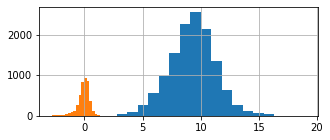

In [815]:
RNA_matrix.iloc[:, 90].hist(bins=20, figsize=(5,2))
protein_matrix.mean(axis=1).hist(bins=20,figsize=(5,2))

In [820]:
common_genes = list(set(RNA_matrix.index) & set(protein_matrix.index))
X, Y=RNA_matrix.loc[common_genes] , protein_matrix.loc[common_genes] 
print(len(common_genes))
percent=0.1
# # subset X to reduce dimension
cv=X.std(axis=1)/X.mean(axis=1)
mask = cv.rank(ascending=False) <= X.shape[0]*percent
print(mask.sum())

cv=Y.std(axis=1)/Y.mean(axis=1)
mask = (cv.rank(ascending=False) <= Y.shape[0]*percent) | mask
print(mask.sum())

X = X.loc[mask].transform(lambda x: (x-x.mean())/x.std(), axis=1)
Y = Y.loc[mask].transform(lambda x: (x-x.mean())/x.std(), axis=1)
common_genes = list(set(X.index) & set(X.index))
temp = pd.Series(index=common_genes,  data = [ stats.pearsonr(X.loc[g,:], Y.loc[g,:])[0] for g in common_genes ])
print(temp.median())
print(np.median([ stats.spearmanr(X.loc[g,:], Y.loc[g,:])[0] for g in common_genes ]))

X.shape, Y.shape, temp.mean()

4201
420
814
0.3579742525824101
0.34621690626387996


((814, 95), (814, 95), 0.3455354546342947)

In [821]:
if False:
    output="/media/eys/xwj/proteome/data/colon_2019/protein_matrix_4375row95col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)
    output="/media/eys/xwj/proteome/data/colon_2019/RNA_matrix_12932row95col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)

### breast_77_2016_itraq
Breast 2016 20210308
protein abunance Table S3； RNA=xenabrowser TCGA 1217samples,
remove any rows have NAs.  
Protein(6332, 77)   RNA (18129, 77)

In [115]:
input="/media/eys/xwj/proteome/data/breast_2016/protein.sample.ids"
protein_samples=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=None)
input="/media/eys/xwj/proteome/data/breast_2016/RNA.sample.ids"
RNA_samples=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=None)


input="/media/eys/xwj/proteome/data/breast_2016/protein.raw.txt"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
mask = pd.notnull(protein_raw["geneName"])
protein_raw = protein_raw[mask].reset_index().drop(columns=["accession_number"]).set_index("geneName")
mask = pd.notna(protein_raw).all(axis =1)
protein_matrix = protein_raw[mask]

protein_matrix = protein_matrix[ protein_samples["protein.raw"] ]
protein_matrix.columns = protein_samples["protein"]

protein_matrix = protein_matrix.groupby("geneName").max().groupby(axis=1, level=0).mean().sort_index(axis=1).round(3)
protein_matrix.shape

(6338, 77)

In [1433]:
protein_matrix_new_index = symbol2ensembl(protein_matrix)
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]

6332


In [1437]:
protein_matrix = protein_matrix.groupby(protein_matrix.index).max()
protein_matrix.shape

(6328, 77)

In [ ]:
input="/media/eys/xwj/proteome/data/breast_2016/TCGA-BRCA.htseq_fpkm-uq.tsv"
use_columns = ["Ensembl_ID"] + list(RNA_samples["RNA.raw.TCGAID"])
RNA_raw =pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0, usecols = use_columns)
RNA_raw.columns = RNA_samples["RNA"]
mask = RNA_raw.all(axis=1)
RNA_matrix = RNA_raw[mask].sort_index(axis=1).round(3)
RNA_matrix.index = [ str(x).split(sep=".")[0] for x in RNA_matrix.index ]

In [176]:
## load QC passed 77 samples ids
input="/media/eys/xwj/proteome/data/breast_2016/CPTAC_BC_SupplementaryTable01_sample_annotation.xlsx"
sample_anno = pd.read_excel(input, header=0, index_col=None)
sample77 = [ x[5:15] for x in sample_anno.loc[sample_anno["QC Status"] == "pass", "Biospecimen Barcode Side"] ]

input="/media/eys/xwj/proteome/data/breast_2016/TCGA_Breast_BI_Proteome.itraq.tsv"
protein_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
protein_raw = protein_raw.loc[pd.notna( protein_raw["Authority"] )].set_index("Authority")
mask_cols = [ x.endswith("Unshared Log Ratio")  for x in protein_raw.columns]
protein_raw = protein_raw.loc[:, mask_cols]
protein_raw.columns = [x.split(" ")[0][:10] for x in protein_raw.columns ]
protein_raw = protein_raw.groupby(axis=1, level=0).mean()

input="/media/eys/xwj/proteome/data/breast_2016/gdac.broadinstitute.org_BRCA.mRNAseq_Preprocess.Level_3.2016012800.0.0/BRCA.uncv2.mRNAseq_RSEM_normalized_log2.txt"
RNA_raw=pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
RNA_raw.index =[x.split("|")[0] for x in RNA_raw.index ]
RNA_raw.columns =[x[5:15] for x in RNA_raw.columns ]

RNA_matrix = RNA_raw[sample77]

In [187]:
RNA_matrix_new_index = symbol2ensembl(RNA_matrix)
RNA_matrix.index = RNA_matrix_new_index.ensembl_gene_id

##################17763


In [202]:
RNA_matrix = RNA_matrix[pd.notna(RNA_matrix.index)].dropna()

In [ ]:
protein_matrix = protein_raw[ sample77 ]
mask = protein_matrix.index.isin(hgnc["hgnc_id"]) & pd.notnull(protein_matrix).all(axis=1)
protein_matrix = protein_matrix[mask]
protein_matrix.index = hgnc.set_index("hgnc_id").loc[ protein_matrix.index, "ensembl_gene_id"]
protein_matrix = protein_matrix.groupby(axis=0, level =0).max() 

In [229]:
RNA_matrix = RNA_matrix.groupby(axis=0, level =0).max()
RNA_matrix.shape,  protein_matrix.shape

((14056, 77), (6995, 77))

In [230]:
if False:
    output="/media/eys/xwj/proteome/data/breast_2016/RNA_matrix_18129row77col.txt"
    output="/media/eys/xwj/proteome/data/breast_2016/RNA_matrix_14056row77col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
if False:
    output="/media/eys/xwj/proteome/data/breast_2016/protein_matrix_6328row77col.txt"
    output="/media/eys/xwj/proteome/data/breast_2016/protein_matrix_6995row77col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

## ovary_119_2016_itraq
Ovary 2016 20210308
174 patients, 
remove any rows have NAs.  
Protein(   RNA 

In [1448]:
# inputfile ='/media/eys/xwj/proteome/data/ovary_2016/OvaryProteinAbundance_1-s2.0-S0092867416306730-mmc3.xlsx'
protein_raw = pd.read_csv('/media/eys/xwj/proteome/data/ovary_2016/protein.raw.clean.txt', sep="\t", low_memory=False, header=0, index_col=0)
mask = pd.notnull(protein_raw["hgnc_symbol"])
protein_raw = protein_raw[mask].set_index("hgnc_symbol")#.drop(columns=["refseq_peptide"])

In [1449]:
new_index = pd.DataFrame(protein_raw.index)
mask = protein_raw.index.isin(excel_error_genesymbol_mapping.index)
new_index.loc[mask,"hgnc_symbol"] = excel_error_genesymbol_mapping.loc[protein_raw.index[mask], "Correct"].values
protein_raw.index = new_index.hgnc_symbol

protein_raw = protein_raw.groupby(by=protein_raw.index).max()
protein_matrix_new_index = symbol2ensembl(protein_raw)
protein_raw.index = protein_matrix_new_index.ensembl_gene_id

9166


In [1450]:
protein_matrix = protein_raw
protein_matrix.columns  = [ "-".join(x.split(sep="-")[1:]) for x in protein_matrix.columns ]

In [1451]:
protein_matrix = protein_matrix.groupby(axis=1, level=0).mean()
mask = pd.notnull(protein_matrix).all(axis=1)
protein_matrix  = protein_matrix[mask].round(3)

In [1460]:
protein_matrix = protein_matrix.groupby(protein_matrix.index).max()

In [1461]:
inputfile ='/media/eys/xwj/proteome/data/ovary_2016/TCGA-OV.htseq_fpkm-uq379patients.tsv'
RNA_raw = pd.read_csv(inputfile, sep="\t",low_memory=False, header=0, index_col=0)

In [ ]:
mask = RNA_raw.all(axis=1) 
RNA_matrix = RNA_raw[mask].sort_index(axis=1)
RNA_matrix.index = [ str(x).split(sep=".")[0] for x in RNA_matrix.index ]

RNA_matrix.columns = [ "-".join(x.split(sep="-")[:3]) for x in RNA_matrix.columns ]
RNA_matrix = RNA_matrix.groupby(axis=1, level=0).mean().round(3)
RNA_matrix.head()

In [1466]:
common= set(RNA_matrix.columns) & set(protein_matrix.columns)
RNA_matrix = RNA_matrix[common]
protein_matrix = protein_matrix[common]
RNA_matrix.shape, protein_matrix.shape

((16697, 119), (4251, 119))

In [1468]:
if False:
    output="/media/eys/xwj/proteome/data/ovary_2016/RNA_matrix_16697row119col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/ovary_2016/protein_matrix_4251row119col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### brain_108_2021_tmt
Brain 2021 20210308   
108 patients, protein  ((9, 108),  RNA (21542, 108))

Table S2(tab5“gene_expression_fpkm_uq”+tab8“proteome_normalized”). Global proteome data; log2 transformed, normalized by median polishing and batch corrected by Combat. 


In [439]:
inputfile ='/media/eys/xwj/proteome/data/brain_2021/tab5_gene_expression_fpkm_uq.txt'
RNA_raw = pd.read_csv(inputfile, sep="\t",low_memory=False, header=0, index_col=0)
RNA_raw = RNA_raw.drop(columns=["gene_name", "gene_type", "gene_status"])
mask = pd.notnull(RNA_raw).all(axis=1)
RNA_matrix = np.log2(RNA_raw[mask] +1).sort_index(axis=1).round(3)
RNA_matrix.index = [ str(x).split(sep=".")[0] for x in RNA_matrix.index ]
RNA_matrix

,C3L-00104,C3L-00365,C3L-00674,C3L-00677,C3L-01040,C3L-01043,C3L-01045,C3L-01046,C3L-01048,C3L-01049,...,C3N-03473,PT-NPJ7,PT-P44H,PT-QVJO,PT-R55F,PT-RN5K,PT-RU72,PT-UTHO,PT-WVLH,PT-Y8DK
ENSG00000230415,17.428,16.944,16.126,17.122,16.155,16.123,16.132,16.736,17.516,16.858,...,16.141,16.212,15.831,16.635,17.204,17.533,17.091,16.749,15.394,16.124
ENSG00000213842,15.844,15.894,15.383,15.986,15.283,15.737,15.444,14.995,15.616,15.601,...,15.570,15.238,14.645,15.009,15.544,15.742,15.116,15.610,13.110,13.272
ENSG00000206557,13.070,9.518,13.702,14.521,12.074,12.713,14.152,10.627,14.065,13.519,...,16.164,12.863,13.814,13.302,13.573,12.597,13.148,13.252,13.077,13.257
ENSG00000170266,17.665,17.921,18.027,18.314,18.097,18.200,17.976,18.747,17.618,18.899,...,18.396,17.079,17.011,17.320,17.132,17.177,17.339,17.142,17.115,17.116
ENSG00000188167,16.167,16.250,16.211,15.993,16.700,16.043,16.331,16.944,16.558,16.679,...,16.129,16.895,16.123,16.949,16.567,16.786,16.856,16.459,16.382,16.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000170293,14.864,12.906,15.104,14.780,14.442,13.949,13.964,14.752,13.286,14.970,...,16.437,13.995,14.402,14.703,14.436,15.158,14.383,14.702,14.632,14.053
ENSG00000153551,14.114,14.552,15.894,13.782,14.747,15.911,15.195,16.846,14.332,15.975,...,14.736,12.904,12.376,13.090,12.397,12.839,11.222,12.254,11.501,11.305
ENSG00000091317,18.007,18.095,18.814,17.690,17.917,18.701,17.831,19.045,17.110,18.441,...,18.763,16.438,16.576,16.425,16.272,16.725,16.381,15.801,16.309,16.302
ENSG00000144635,16.291,17.076,17.276,16.753,16.775,16.991,16.897,16.871,16.623,17.036,...,17.402,17.682,17.633,17.687,17.576,16.742,17.544,17.579,18.185,17.968


In [429]:
# inputfile ='/media/eys/xwj/proteome/data/brain_2021/1-s2.0-S1535610821000507-mmc3.xlsx'
# protein_raw = pd.read_excel(inputfile, sheet_name="proteome_normalized")
inputfile ='/media/eys/xwj/proteome/data/brain_2021/tab8_proteome_normalized.txt'
protein_raw = pd.read_csv(inputfile, sep="\t",low_memory=False, header=0, index_col=0)

# RNA have 108 samples, protein have 109 samples.
mask = protein_raw.hgnc_id.isin(hgnc["hgnc_id"]) & pd.notnull(protein_raw).all(axis=1)
protein_raw = protein_raw[mask]
protein_raw.index = hgnc.set_index("hgnc_id").loc[ protein_raw.hgnc_id, "ensembl_gene_id"]
protein_matrix = protein_raw.drop(columns=["refseq_prot_id", "hgnc_id"]).loc[:, RNA_matrix.columns]
protein_matrix

,C3L-00104,C3L-00365,C3L-00674,C3L-00677,C3L-01040,C3L-01043,C3L-01045,C3L-01046,C3L-01048,C3L-01049,...,C3N-03473,PT-NPJ7,PT-P44H,PT-QVJO,PT-R55F,PT-RN5K,PT-RU72,PT-UTHO,PT-WVLH,PT-Y8DK
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.078,-0.146,0.822,-0.065,-0.764,1.095,-0.028,-0.376,-0.395,-0.026,...,-0.899,-1.718,-1.358,-1.540,-1.789,-1.624,-1.452,-1.903,-2.004,-1.590
ENSG00000175899,0.487,0.799,1.096,0.129,-1.032,0.769,-0.736,-0.038,-0.485,-0.310,...,-0.333,-1.064,-0.807,-1.248,-1.478,-1.164,-1.147,-1.162,-1.606,-1.227
ENSG00000094914,-0.254,0.184,-0.094,0.048,-0.217,-0.011,0.126,0.240,0.208,0.087,...,0.404,-0.307,-0.580,-0.672,-0.765,-0.571,-0.373,-0.412,-0.695,-0.487
ENSG00000081760,-0.144,-0.471,-0.106,-0.118,-0.696,-0.152,-0.285,0.152,-0.033,-0.163,...,-0.570,0.436,0.556,0.917,0.857,0.608,0.584,0.535,0.818,0.866
ENSG00000103591,-0.467,0.245,-0.248,0.304,-0.052,-0.106,0.167,-0.134,-0.047,0.092,...,0.423,0.223,0.188,0.538,0.258,0.136,-0.074,-0.383,0.060,0.137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000086827,-0.106,-0.213,-0.307,0.464,0.011,0.119,0.051,0.004,0.131,0.061,...,0.071,0.020,-0.199,-0.098,-0.110,-0.404,0.003,-0.172,-0.245,-0.185
ENSG00000162378,0.079,0.049,-0.172,0.178,0.113,-0.271,-0.047,0.118,-0.172,-0.340,...,-0.340,0.768,0.380,0.667,0.563,0.609,0.637,0.616,0.732,0.624
ENSG00000159840,-0.785,0.138,0.012,-0.720,1.005,0.371,0.761,0.964,-0.403,0.271,...,-0.125,-1.128,-1.088,-1.172,-0.973,-1.293,-0.796,-0.735,-1.159,-0.893


In [433]:
if False:
    output="/media/eys/xwj/proteome/data/brain_2021/RNA_matrix_21542row108col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/brain_2021/protein_matrix_8825row108col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### stomach_80_2019_itraq
stomcach 2019 20210308

protein Unshared Log Ratio. two independent biological replicates were averaged if necessary.

RNA GSE122401 CPM by RSEM 

108 patients, protein ((9, 108), RNA (21542, 108))

In [520]:
inputfile ='/media/eys/xwj/proteome/data/stomach_2019/Gastric_Cancer_Korea_Proteome.itraq.tsv'
protein_raw = pd.read_csv(inputfile, sep="\t",low_memory=False, header=0, index_col=0)
protein_raw = protein_raw.set_index("Authority")
mask_cols = [ x.startswith("Unshared")  for x in protein_raw.columns]
mask_rows = pd.notnull(protein_raw.index)
protein_raw = protein_raw.loc[mask_rows, mask_cols]
protein_raw.index = hgnc.set_index("hgnc_id").loc[ protein_raw.index, "ensembl_gene_id"]
# 
mask = pd.notnull(protein_raw).all(axis=1)
protein_matrix = protein_raw[mask].sort_index(axis=1)
origname = list(protein_matrix.columns) 
shortname =  [ s.split("Unshared Log")[1].split(".")[0].split("T")[1].split("/")[0] + "T" for s in origname ]
protein_matrix.columns = shortname
protein_matrix = protein_matrix.groupby(axis=1, level=0).mean().sort_index(axis=1).round(3)

protein_matrix

,112T,116T,118T,120T,124T,132T,136T,138T,140T,144T,...,5760T,60T,62T,64T,66T,68T,88T,90T,92T,96T
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,1.069,0.526,0.881,0.917,0.328,-0.359,0.092,0.276,1.436,-0.573,...,-0.393,0.952,0.595,0.411,0.817,1.911,0.561,0.306,0.234,0.110
ENSG00000175899,1.193,0.769,0.680,0.823,0.488,-0.308,0.216,0.311,1.678,-0.729,...,-0.428,0.819,0.539,0.539,0.970,2.071,0.820,0.415,0.232,0.423
ENSG00000094914,0.009,0.042,0.378,0.002,-0.028,0.485,0.373,0.272,-0.330,0.096,...,-0.015,-0.082,-0.048,0.200,-0.284,-0.397,-0.232,-0.213,0.018,0.130
ENSG00000081760,-0.788,-0.495,-0.736,-0.742,0.067,-0.289,-0.941,-0.368,-0.549,-0.383,...,-0.391,-0.298,-0.842,-0.941,-0.553,-1.067,-0.307,0.250,-0.210,-0.786
ENSG00000114771,-1.329,-0.241,-1.745,-0.128,-0.641,-1.103,-1.374,-0.787,-1.478,-0.261,...,-0.517,-1.349,-0.558,-1.065,-0.448,-0.874,-0.511,-0.206,0.080,0.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000109917,0.076,0.131,0.158,0.274,-0.051,0.370,0.090,0.071,-0.186,0.280,...,0.087,0.098,0.095,0.088,-0.130,0.272,0.247,0.006,0.033,0.387
ENSG00000132485,0.078,0.144,0.182,0.206,0.033,0.432,0.210,-0.110,0.055,-0.188,...,-0.333,0.013,0.037,-0.059,-0.457,-0.039,0.142,0.078,0.081,0.188
ENSG00000086827,-0.277,-0.256,-0.109,-0.244,-0.009,0.116,-0.049,-0.046,-0.419,-0.183,...,-0.242,-0.385,-0.213,0.005,-0.382,-0.359,-0.048,-0.015,-0.130,-0.012


In [479]:
file = "/media/eys/xwj/proteome/data/stomach_2019/GSE122401/gene.list"
df_gene = pd.read_csv(file, sep="\t", skiprows=0, index_col=0)

sample_info=pd.read_csv("/media/eys/xwj/proteome/data/stomach_2019/my_sample_filename.txt",  
                    sep="\t", index_col=None,low_memory=False)
# for sp in sample_info["file"]: 
for index, sp in sample_info.iterrows():
    file="/media/eys/xwj/proteome/data/stomach_2019/GSE122401/"+sp["file"]
    df=pd.read_csv(file, sep="\t")
    df_gene.loc[:, sp["sample"]]=df.iloc[:, -1].values

In [528]:
RNA_raw = df_gene
mask = (RNA_raw > 0).all(axis=1)
RNA_matrix = np.log2(RNA_raw.loc[mask, protein_matrix.columns] +1).sort_index(axis=1).round(3)
RNA_matrix

,112T,116T,118T,120T,124T,132T,136T,138T,140T,144T,...,5760T,60T,62T,64T,66T,68T,88T,90T,92T,96T
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,9.795,9.658,10.825,9.498,9.629,9.909,9.471,9.170,8.895,10.222,...,9.371,10.902,9.551,11.100,9.833,8.758,9.322,9.441,9.431,10.508
ENSG00000000419,9.396,9.821,9.624,9.588,9.688,9.391,9.466,9.914,9.280,9.220,...,9.433,9.762,9.441,10.463,9.885,9.580,9.708,9.272,9.951,9.905
ENSG00000000457,9.211,9.570,9.913,9.306,9.467,9.478,8.849,8.852,9.576,9.388,...,9.113,9.252,9.144,9.322,9.499,9.387,9.031,9.368,9.038,9.078
ENSG00000000460,7.857,8.461,9.299,8.584,8.282,8.801,8.338,8.243,8.770,8.163,...,7.691,8.026,8.280,9.095,8.010,8.522,8.226,8.039,7.954,8.155
ENSG00000000938,9.031,8.055,8.366,7.985,8.406,7.371,9.181,8.389,10.129,8.617,...,8.514,10.061,8.217,8.675,8.588,8.717,9.305,9.292,8.509,8.568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000272916,9.568,9.424,10.026,9.314,9.353,9.032,9.406,9.124,9.886,9.596,...,8.902,10.024,9.020,9.368,9.605,9.666,9.770,9.593,9.460,9.391
ENSG00000272962,8.921,9.161,9.797,9.598,9.585,8.282,8.854,7.929,7.593,8.225,...,7.906,8.935,7.355,8.772,9.328,7.656,9.197,8.103,9.024,7.146
ENSG00000273045,6.145,6.125,5.756,6.699,6.713,6.429,5.850,7.098,5.088,5.616,...,5.388,5.842,6.586,6.262,6.651,4.501,5.649,6.082,5.682,5.657


In [532]:
if False:
    output="/media/eys/xwj/proteome/data/stomach_2019/RNA_matrix_15091row80col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/stomach_2019/protein_matrix_4900row80col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### pedbrain_188_2020_tmt 
pedbrain 2020 20210318  
Francesca Petralia,Nicole Tignor,Boris Reva, et al., (2020) Cell 183, 1962-1985  
https://cptac-data-portal.georgetown.edu/cptacPublic/  
version 1. protein Gygi_TCMP_HMS_Proteome.tmt11.tsv matrix take "Unshared Log Ratio" 

20210409 
version 2. TMTData/ProteoData/ProcessedProteoData/proteo_tumorall_nofilter_imputedA_03162020.tsv

rna_data_0316_2020.tsv
-- Gene level expression data table.
-- 188 samples in total.
-- STAR v2.6.1d (Dobin et al., 2013) was used to align paired-end RNA-seq reads against the ENSEMBL GENCODE 27 揅omprehensive gene annotation?reference.
-- RSEM v1.3.1 (Li and Dewey, 2011) was used to generate gene-level expression values (FPKM). 
--log2(x+1) transform was applied.
--Samples with replicates were averaged. 

In [752]:
## version 2 
inputfile ='/media/eys/xwj/proteome/data/pedbrain_2020/TMTData/ProteoData/ProcessedProteoData/proteo_tumorall_nofilter_imputedA_03162020.tsv'
# inputfile ='/media/eys/xwj/proteome/data/pedbrain_2020/TMTData/ProteoData/proteo_tumorall_preimputation.tsv'

protein_raw = pd.read_csv(inputfile, sep="\t",low_memory=False, header=0, index_col=0)
protein_matrix = protein_raw.drop(columns="Prot_Desc").dropna(axis=0)

In [700]:
protein_matrix_new_index=symbol2ensembl(protein_matrix)

#######6426


In [754]:
mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix = protein_matrix[mask]
protein_matrix.index = protein_matrix_new_index.loc[mask, "ensembl_gene_id"]

In [772]:
inputfile ='/media/eys/xwj/proteome/data/pedbrain_2020/GenomicData/rna_data_0316_2020.tsv'
RNA_raw = pd.read_csv(inputfile, sep="\t",low_memory=False, header=0, index_col=0)
RNA_matrix = RNA_raw.drop(columns="Prot_Desc").dropna(axis=0)

In [662]:
RNA_matrix_new_index=symbol2ensembl(RNA_matrix)

###################18199


In [773]:
mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]

In [776]:
common = set(protein_matrix.columns) & set(RNA_matrix.columns)
RNA_matrix = RNA_matrix.loc[:, common]
protein_matrix = protein_matrix.loc[:, common]

In [794]:
RNA_matrix     =  RNA_matrix.groupby(RNA_matrix.index).max().round(3).sort_index(axis=1)
protein_matrix = protein_matrix.groupby(protein_matrix.index).max().round(3).sort_index(axis=1)

In [799]:
if False:
    output="/media/eys/xwj/proteome/data/pedbrain_2020/RNA_matrix_18197row188col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/pedbrain_2020/protein_matrix_6425row188col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### headneck_151_2021_tmt
headneck 2021 

In [1709]:
protein_raw1=pd.read_csv("/media/eys/xwj/proteome/data/headneck_2021/HS_CPTAC_HNSCC_Proteomics_TMT_Gene_level_Normal.cct", 
                         sep="\t", low_memory=False, header=0, index_col=0)
protein_raw2=pd.read_csv("/media/eys/xwj/proteome/data/headneck_2021/HS_CPTAC_HNSCC_Proteomics_TMT_Gene_level_Tumor.cct", 
                         sep="\t", low_memory=False, header=0, index_col=0)
protein_raw1.columns = [ col + "N" for col in protein_raw1.columns]
protein_raw2.columns = [ col + "T" for col in protein_raw2.columns]

protein_raw = pd.concat([protein_raw1, protein_raw2], axis=1)
protein_matrix = protein_raw.dropna(axis=0)

protein_matrix_new_index=symbol2ensembl(protein_matrix)

mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
protein_matrix = protein_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

In [1710]:
protein_matrix

,C3N-01858N,C3L-00997N,C3N-03849N,C3N-01859N,C3N-03933N,C3L-00999N,C3N-03781N,C3N-03015N,C3N-01620N,C3N-03012N,...,C3N-00828T,C3N-00297T,C3N-00295T,C3N-00829T,C3N-00306T,C3N-00846T,C3L-02617T,C3N-00498T,C3N-00299T,C3N-00307T
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,24.056,24.975,23.474,24.082,22.708,24.602,24.986,22.590,23.908,24.259,...,23.136,22.533,23.458,22.711,23.190,22.691,25.030,22.951,22.465,23.153
ENSG00000000419,25.559,25.478,25.292,25.345,25.125,25.524,25.416,25.128,25.432,25.534,...,25.858,25.146,25.728,25.191,26.096,25.586,25.806,25.046,25.588,25.594
ENSG00000000457,25.380,25.935,25.214,25.516,25.201,25.691,25.304,25.201,25.392,25.641,...,25.136,25.067,25.632,24.685,24.909,25.329,24.702,25.444,24.939,25.275
ENSG00000000938,23.506,23.799,23.701,23.577,23.950,23.746,23.365,23.539,22.918,22.888,...,24.269,24.122,24.663,24.805,23.992,24.014,24.140,23.595,24.296,24.329
ENSG00000000971,29.802,29.184,30.377,29.572,29.905,29.292,29.797,30.036,28.741,28.888,...,28.382,28.077,28.547,28.711,28.728,28.500,28.381,28.247,28.692,29.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000284194,24.391,24.631,24.285,24.521,23.940,24.458,24.325,24.621,24.508,24.841,...,24.451,24.212,24.433,23.744,24.132,24.524,24.378,24.550,24.201,24.514
ENSG00000284505,25.497,24.040,24.596,24.866,24.923,24.405,25.381,25.124,24.129,26.181,...,25.649,26.105,24.597,23.137,24.523,24.204,22.751,22.747,24.745,21.598
ENSG00000284753,21.508,21.996,22.094,22.022,22.058,22.063,21.992,22.028,21.994,22.013,...,22.680,22.227,22.511,23.643,22.306,21.714,23.478,23.371,22.134,22.517


In [1712]:
RNA_raw1=pd.read_csv("/media/eys/xwj/proteome/data/headneck_2021/HS_CPTAC_HNSCC_RNAseq_RSEM_UQ_log2_Normal.cct", 
                         sep="\t", low_memory=False, header=0, index_col=0)
RNA_raw2=pd.read_csv("/media/eys/xwj/proteome/data/headneck_2021/HS_CPTAC_HNSCC_RNAseq_RSEM_UQ_log2_Tumor.cct", 
                         sep="\t", low_memory=False, header=0, index_col=0)
RNA_raw1.columns = [ col + "N" for col in RNA_raw1.columns]
RNA_raw2.columns = [ col + "T" for col in RNA_raw2.columns]

RNA_raw = pd.concat([RNA_raw1, RNA_raw2], axis=1)
RNA_matrix = RNA_raw.dropna(axis=0)

In [1713]:
RNA_matrix_new_index=symbol2ensembl(RNA_matrix) 
mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]
RNA_matrix = RNA_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

In [1714]:
RNA_matrix = RNA_matrix[RNA_matrix.all(axis=1)]

In [1715]:
RNA_matrix

,C3L-00977N,C3L-00994N,C3L-00995N,C3L-00997N,C3L-00999N,C3L-01237N,C3L-02617N,C3L-02621N,C3L-02651N,C3L-03378N,...,C3N-03933T,C3N-04152T,C3N-04273T,C3N-04275T,C3N-04276T,C3N-04277T,C3N-04278T,C3N-04279T,C3N-04280T,C3N-04611T
ensembl_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,13.07,10.77,10.16,11.34,11.28,10.97,12.92,12.18,11.82,10.84,...,9.46,10.62,10.92,10.29,10.51,10.13,11.43,9.52,9.96,10.95
ENSG00000000419,10.61,10.05,9.97,10.10,9.95,9.80,10.20,10.09,10.06,9.84,...,10.28,10.32,9.56,9.79,9.80,10.47,9.82,10.31,10.44,10.95
ENSG00000000457,10.56,10.02,9.62,9.91,10.11,10.01,10.25,10.22,10.02,9.98,...,9.73,9.91,10.14,10.06,10.80,9.94,9.14,9.71,9.98,9.77
ENSG00000000460,8.59,8.52,8.35,8.36,8.45,8.38,8.53,8.48,8.40,8.26,...,9.55,9.99,10.21,9.01,11.09,9.04,9.73,9.82,8.69,10.19
ENSG00000000938,7.26,6.39,8.83,8.82,8.60,6.93,7.22,8.34,7.57,7.31,...,8.60,7.97,7.29,8.45,6.73,8.79,8.60,7.63,7.51,9.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000287151,8.59,7.51,9.07,8.56,8.19,8.29,9.07,8.88,8.42,8.56,...,9.14,9.17,11.49,10.26,10.80,10.09,9.76,11.19,8.84,11.23
ENSG00000288235,6.18,5.07,3.98,3.70,4.85,3.96,3.77,4.71,2.85,5.10,...,3.60,6.21,4.79,5.70,6.88,6.39,4.06,4.02,6.90,5.76
ENSG00000288547,4.60,3.35,4.23,5.01,3.85,3.80,4.13,3.95,3.54,4.27,...,6.83,4.94,3.91,5.00,3.58,5.24,4.86,4.72,6.24,4.09


In [1721]:
common = set(protein_matrix.columns) & set(RNA_matrix.columns)
protein_matrix = protein_matrix[common]
RNA_matrix = RNA_matrix[common]
RNA_matrix.shape, protein_matrix.shape

((16776, 151), (7511, 151))

In [1722]:
if False:
    output="/media/eys/xwj/proteome/data/headneck_2021/RNA_matrix_16776row151col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/headneck_2021/protein_matrix_7511row151col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### renal_185_2019_tmt
renal 2019 2021.4.13

In [893]:
protein_raw=pd.read_csv("/media/eys/xwj/proteome/data/renal_2019/6_CPTAC3_CCRCC_Whole_abundance_gene_protNorm=2_CB.tsv", 
                         sep="\t", low_memory=False, header=0, index_col=0)

RNA_raw=pd.read_csv("/media/eys/xwj/proteome/data/renal_2019/RNA_rpkm_tumor_normal.tsv", 
                         sep="\t", low_memory=False, header=0, index_col=0)
sample_meta = pd.read_csv("/media/eys/xwj/proteome/data/renal_2019/sample_meta.txt", 
                         sep="\t", low_memory=False, header=0, index_col=0)

In [894]:
protein_raw = protein_raw.loc[:, sample_meta["Aliquot ID"].values]
RNA_raw = RNA_raw[sample_meta["RNAlabel"]]
RNA_raw.columns = sample_meta.index
protein_raw.columns = sample_meta.index
print(protein_raw.shape, RNA_raw.shape)

(11355, 185) (19293, 185)


In [905]:
protein_raw = protein_raw.dropna(axis=0)
RNA_raw = RNA_raw.dropna(axis=0)
protein_matrix = protein_raw
RNA_matrix = RNA_raw.groupby(RNA_raw.index).max() ## RNA

In [908]:
protein_matrix_new_index=symbol2ensembl(protein_matrix)

mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
protein_matrix = protein_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

########7147


In [909]:
RNA_matrix_new_index=symbol2ensembl(RNA_matrix) 
mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]
RNA_matrix = RNA_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

####################19113


In [924]:
RNA_matrix = RNA_matrix[ RNA_matrix.all(axis=1) ]

((6933, 185), (6933, 185), (14636, 185), (7146, 185))

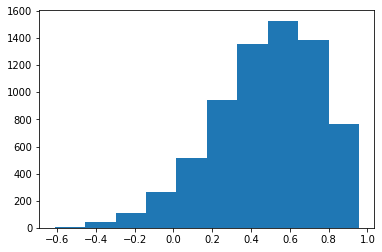

In [929]:
gene_list = set(protein_matrix.index.values) & set(RNA_matrix.index.values)
temp = [stats.pearsonr(RNA_matrix.loc[g, :] , protein_matrix.loc[g,:])[0] for g in gene_list ]
plt.hist(temp)

In [930]:
if False:
    output="/media/eys/xwj/proteome/data/renal_2019/RNA_matrix_14636row185col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/renal_2019/protein_matrix_7146row185col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### breast_122_2020_tmt

In [509]:
file = "/media/eys/xwj/proteome/data/breast2020/S060_Breast_Cancer_data_freeze_GCTfiles_v5.4-public/prosp-brca-v5.4-public-rnaseq-fpkm-log2.gct"
RNA_raw = pd.read_csv(file, sep="\t", skiprows=2, index_col=0,  low_memory=False)
RNA_raw = RNA_raw.iloc[54:, ]
RNA_raw = RNA_raw.drop(columns=['geneSymbol', 'description']).dropna(axis=0).astype(np.float64)
RNA_raw

,CPT000814,CPT001846,X01BR001,X01BR008,X01BR009,X01BR010,X01BR015,X01BR017,X01BR018,X01BR020,...,X20BR002,X20BR005,X20BR006,X20BR007,X20BR008,X21BR001,X21BR002,X21BR010,X22BR005,X22BR006
id,,,,,,,,,,,,,,,,,,,,,
A2M,5.3718,5.3253,5.4734,5.8701,6.9307,5.5849,6.5595,6.5173,6.4225,6.2846,...,7.5384,6.6644,6.1730,6.8615,7.1951,6.1540,9.0054,6.9516,6.7257,7.3029
A4GALT,0.6260,3.2060,1.8816,0.6957,1.9784,0.7968,1.3805,1.1546,2.6610,0.1757,...,1.1158,-1.7615,-2.0081,-1.6326,-0.8360,1.6543,6.2542,-2.3352,2.3115,1.7685
AAAS,4.7000,4.3115,3.3434,4.3095,4.6341,4.2256,4.3975,3.2817,3.3272,4.1679,...,3.8853,2.8455,3.4614,2.7297,3.3425,5.1404,5.1665,3.4699,4.3077,4.7615
AACS,3.9448,2.7071,3.3353,3.1192,3.9998,5.7535,4.0783,4.0624,2.2837,4.5309,...,4.0508,3.6766,1.9702,2.6914,3.2826,4.0066,4.2556,1.3077,3.2985,3.5601
AADAT,3.8806,3.1017,1.3825,3.4104,1.1957,5.8199,1.0529,2.0050,3.5650,3.5225,...,1.6676,3.4649,1.7549,1.8389,3.0206,-1.0626,-0.0335,0.9417,-0.2233,0.8193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,5.1699,3.2163,2.8806,3.2620,3.0986,3.4205,1.9207,3.7417,3.3365,2.6126,...,2.6922,2.8318,3.1465,2.5487,3.1767,4.9094,5.1380,3.2352,2.4904,2.6225
ZYG11B,0.9835,2.0909,1.5682,0.2989,1.3036,1.4754,2.3020,1.7353,2.2652,1.5354,...,2.2912,3.0045,2.5445,3.1303,2.3503,1.2552,1.5275,2.7830,1.6893,3.0970
ZYX,5.9499,7.0671,4.3852,5.4697,5.0219,7.0262,4.7497,4.6468,4.3992,4.6487,...,5.6449,3.6189,2.1405,3.9298,4.5802,5.5590,6.1792,3.9970,4.1113,6.3228


In [510]:
file = "/media/eys/xwj/proteome/data/breast2020/S060_Breast_Cancer_data_freeze_GCTfiles_v5.4-public/prosp-brca-v5.4-public-proteome-ratio-norm-NArm.gct"
protein_raw = pd.read_csv(file, sep="\t", skiprows=2, index_col=0, low_memory=False)
protein_raw = protein_raw.iloc[54:, ].set_index('geneSymbol')
protein_raw = protein_raw.iloc[: , 14:].dropna( axis=0 ).sort_index(axis=1).astype(np.float64)
protein_raw = protein_raw.groupby(protein_raw.index).max()
protein_raw

,CPT000814,CPT001846,X01BR001,X01BR008,X01BR009,X01BR010,X01BR015,X01BR017,X01BR018,X01BR020,...,X20BR002,X20BR005,X20BR006,X20BR007,X20BR008,X21BR001,X21BR002,X21BR010,X22BR005,X22BR006
geneSymbol,,,,,,,,,,,,,,,,,,,,,
A1BG,-0.6712,1.3964,2.0219,-0.5290,1.2556,-0.3843,1.0394,1.1533,1.9579,-0.1637,...,1.8732,-0.4227,1.5862,-0.2970,1.6767,-0.6610,-1.3735,1.1583,0.4948,0.5049
A2M,-0.2075,1.3302,1.6269,0.3267,3.4489,-1.0239,-0.1915,2.5655,2.4185,-0.5810,...,1.5261,-1.9110,1.6519,1.3457,1.7907,-0.6402,0.4227,0.3329,-1.0986,-0.6582
A2ML1,2.7959,-5.0948,-3.2943,1.4342,2.8043,-5.3604,-3.4196,-0.0396,1.1549,-3.5440,...,4.7528,4.0898,2.4992,3.0502,-2.9086,-4.8578,-4.9553,-5.7358,-8.8314,-7.4699
AAAS,1.3969,0.7674,0.3352,0.4938,-0.2956,0.3739,0.9185,0.5518,0.0683,0.0835,...,1.2963,0.6248,-0.5097,0.5019,0.5231,1.2319,0.6327,-0.1658,0.2826,0.6570
AACS,-1.0899,-1.6845,-1.0739,-2.8676,-1.7261,3.1422,0.0741,0.0241,-3.3943,-1.1122,...,0.1748,0.2093,-1.1763,-0.8595,2.3211,-1.6491,-3.1434,-2.0413,-1.0123,-0.7239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT,1.3910,-0.2137,-0.5316,0.7546,-0.4189,-1.2733,0.7026,1.3190,0.8360,1.3458,...,-0.6227,0.1363,1.7012,0.3162,-0.3044,-0.5570,-1.4444,-0.9444,1.2572,-2.2866
ZYG11B,0.9136,0.0860,0.4996,-0.2499,0.5057,-0.7794,-0.0872,-0.0957,0.3872,-0.5565,...,0.7332,0.3352,-0.0920,0.5750,-0.5377,0.3764,0.4909,0.0650,-1.0698,-0.1334
ZYX,-0.8082,2.5814,0.7622,-0.2590,0.2181,1.5518,1.6941,1.0463,-0.5221,0.5043,...,0.8872,2.5562,-0.6646,1.2669,1.8782,-0.6974,0.3938,0.6300,0.4012,2.5269


In [511]:
RNA_matrix = RNA_raw
protein_matrix = protein_raw

In [545]:
RNA_matrix = RNA_matrix.sort_index(axis=0).drop_duplicates()

In [549]:
protein_matrix_new_index=symbol2ensembl(protein_matrix)

mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
protein_matrix = protein_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

########7582


In [546]:
RNA_matrix_new_index=symbol2ensembl(RNA_matrix) 

mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]
RNA_matrix = RNA_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

###########10169


((5698, 122), (5698, 122), (10163, 122), (7581, 122))

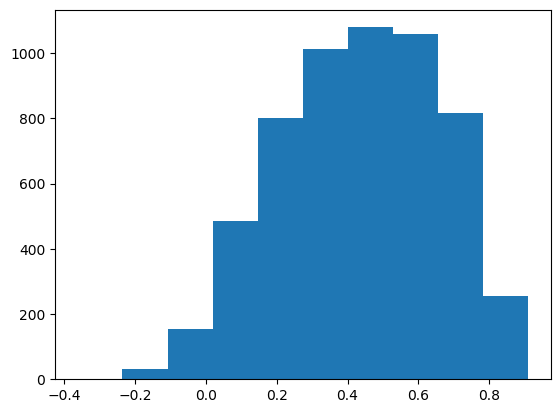

In [550]:
gene_list = set(protein_matrix.index.values) & set(RNA_matrix.index.values)
temp = [stats.pearsonr(RNA_matrix.loc[g, :] , protein_matrix.loc[g,:])[0] for g in gene_list ]
plt.hist(temp)
RNA_matrix.loc[gene_list,:].shape, protein_matrix.loc[gene_list, : ].shape, RNA_matrix.shape, protein_matrix.shape

In [552]:
if False: ## 20210926
    output="/media/eys/xwj/proteome/data/breast2020/RNA_matrix_10163row122col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/breast2020/protein_matrix_7581row122col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### pancrea_140_2021_tmt

In [573]:
file = "/media/eys/xwj/proteome/data/pancrea2021/PDAC_LinkedOmics_Data/mRNA_RSEM_UQ_log2_Tumor.cct"
RNA_raw1 = pd.read_csv(file, sep="\t", skiprows=0, index_col=0,  low_memory=False)
file = "/media/eys/xwj/proteome/data/pancrea2021/PDAC_LinkedOmics_Data/mRNA_RSEM_UQ_log2_Normal.cct"
RNA_raw2 = pd.read_csv(file, sep="\t", skiprows=0, index_col=0,  low_memory=False)
RNA_raw = pd.concat([RNA_raw1, RNA_raw2], axis=1)

file = "/media/eys/xwj/proteome/data/pancrea2021/PDAC_LinkedOmics_Data/proteomics_gene_level_MD_abundance_tumor.cct"
protein_raw1 = pd.read_csv(file, sep="\t", skiprows=0, index_col=0,  low_memory=False)
file = "/media/eys/xwj/proteome/data/pancrea2021/PDAC_LinkedOmics_Data/proteomics_gene_level_MD_abundance_normal.cct"
protein_raw2 = pd.read_csv(file, sep="\t", skiprows=0, index_col=0,  low_memory=False)
protein_raw = pd.concat([protein_raw1, protein_raw2], axis=1 )

In [574]:
len(set(RNA_raw.columns) & set(protein_raw.columns)), len(np.unique(RNA_raw.columns)), len(set(protein_raw.columns))

(140, 140, 148)

In [577]:
RNA_raw = RNA_raw.sort_index(axis=1)
RNA_matrix = RNA_raw.groupby(axis=1, level=0).mean().dropna()

protein_raw = protein_raw.sort_index(axis=1)
protein_matrix = protein_raw.groupby(axis=1, level=0).mean().dropna()

In [274]:
protein_matrix.all(axis=1).value_counts()

True    5750
dtype: int64

In [578]:
RNA_matrix = RNA_matrix[RNA_matrix.all(axis=1) ]
RNA_matrix = RNA_matrix.sort_index(axis=0).drop_duplicates()

In [580]:
protein_matrix_new_index=symbol2ensembl(protein_matrix)

mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
protein_matrix = protein_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

######5749


In [579]:
RNA_matrix_new_index=symbol2ensembl(RNA_matrix) 

mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]
RNA_matrix = RNA_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

##################17177


In [581]:
# match protein and RNA samples
common_sample = set(protein_matrix.columns) & set(RNA_matrix.columns)
RNA_matrix = RNA_matrix[common_sample]
protein_matrix = protein_matrix[common_sample]

In [582]:
len(set(RNA_raw.index & protein_raw.index)), len(set(RNA_matrix.index & protein_matrix.index))

(11651, 5580)

((17165, 140), (5748, 140))

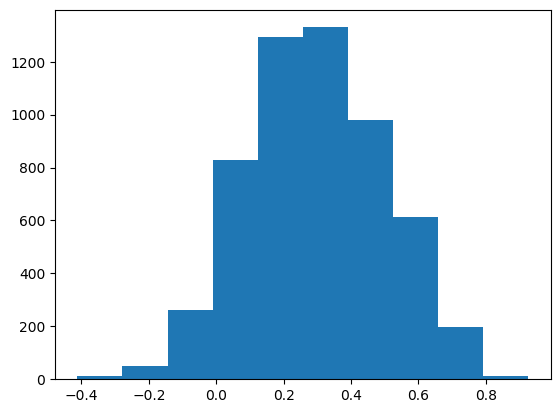

In [583]:
gene_list = set(protein_matrix.index.values) & set(RNA_matrix.index.values)
temp = [stats.pearsonr(RNA_matrix.loc[g, :] , protein_matrix.loc[g,:])[0] for g in gene_list ]
plt.hist(temp)
RNA_matrix.shape, protein_matrix.shape

In [585]:
if False: ## 20210926
    output="/media/eys/xwj/proteome/data/pancrea2021/RNA_matrix_17165row140col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/pancrea2021/protein_matrix_5748row140col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

### lung_202_2021_tmt

#1.3 
11111   207     17      89

lscc-v3.3-public-proteome-ratio-norm-NArm-gene-level.gct -->  Gene-level proteome data matrix (sample/CR). Highest protein subgroup per gene symbol.

#1.3 
21792   202     4       89   
lscc-v3.3-public-rnaseq-uq-fpkm-log2-NArm.gct -->  mRNA data matrix (log2 FPKM).

In [235]:
file = "/media/eys/xwj/proteome/data/lung2021/Satpathy_Supplementary_Data/lscc-v3.3-public-rnaseq-uq-fpkm-log2-NArm.gct"
RNA_raw = pd.read_csv(file, sep="\t", skiprows=2, index_col=0,  low_memory=False)
RNA_raw = RNA_raw.iloc[89:, ]

RNA_raw = RNA_raw.iloc[:, 4: ].dropna(axis=0).astype(np.float64)

In [238]:
file = "/media/eys/xwj/proteome/data/lung2021/Satpathy_Supplementary_Data/lscc-v3.3-public-proteome-ratio-norm-NArm-gene-level.gct"
protein_raw = pd.read_csv(file, sep="\t", skiprows=2, index_col=0,  low_memory=False)
protein_raw = protein_raw.iloc[89:, ]
protein_raw = protein_raw.loc[:, RNA_raw.columns].dropna(axis=0).astype(np.float64)

In [239]:
RNA_raw = RNA_raw.sort_index(axis=1)
RNA_matrix = RNA_raw.groupby(axis=1, level=0).mean().dropna()

protein_raw = protein_raw.sort_index(axis=1)
protein_matrix = protein_raw.groupby(axis=1, level=0).mean().dropna()

In [240]:
protein_matrix_new_index=symbol2ensembl(protein_matrix)

mask=protein_matrix_new_index.ensembl_gene_id.notnull()
protein_matrix=protein_matrix[mask]
protein_matrix.index=protein_matrix_new_index.loc[mask, "ensembl_gene_id"]
protein_matrix = protein_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

#########8213


In [241]:
RNA_matrix_new_index=symbol2ensembl(RNA_matrix) 

mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]
RNA_matrix = RNA_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

#################15592


In [244]:
# match protein and RNA samples
common_sample = set(protein_matrix.columns) & set(RNA_matrix.columns)
RNA_matrix = RNA_matrix[common_sample]
protein_matrix = protein_matrix[common_sample]

In [245]:
len(set(RNA_raw.index & protein_raw.index)), len(set(RNA_matrix.index & protein_matrix.index))

(7822, 7866)

((15587, 202), (8212, 202))

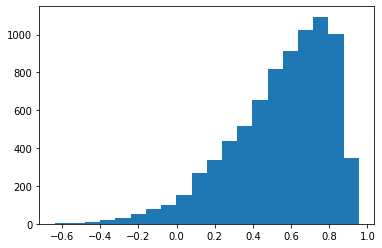

In [247]:
gene_list = set(protein_matrix.index.values) & set(RNA_matrix.index.values)
temp = [stats.pearsonr(RNA_matrix.loc[g, :] , protein_matrix.loc[g,:])[0] for g in gene_list ]
plt.hist(temp, bins=20)
RNA_matrix.shape, protein_matrix.shape

In [248]:
if False: ## 20210924
    output="/media/eys/xwj/proteome/data/lung2021/RNA_matrix_15587row202col.txt"
    RNA_matrix.to_csv(output, sep="\t", index=True, header=True)
    
    output="/media/eys/xwj/proteome/data/lung2021/protein_matrix_8212row202col.txt"
    protein_matrix.to_csv(output, sep="\t", index=True, header=True)

## brain atlas many parts of brains
rnaseq_donor9861: 121 sample= 115 unique sample， 14000+ genes. in them 13400 gene is overlap with **brain_71_2017_labelfree**

In [1512]:
input = "/media/eys/xwj/proteome/gzg20210325_example/rnaseq_donor10021/RNAseqTPM.csv"
RNA_raw2 = pd.read_csv(input, sep=",", low_memory=False, header=None, index_col=0)
input = "/media/eys/xwj/proteome/gzg20210325_example/rnaseq_donor10021/SampleAnnot.csv"
sampleanno = pd.read_csv(input, sep=",", low_memory=False, header=0, index_col=0)
RNA_raw2.columns = sampleanno["sample_name"]

RNA_raw2 = (10**6) * RNA_raw2
RNA_raw2 = np.log2(RNA_raw2 + 1).groupby(axis=1, level=0).mean().round(3)
RNA_matrix2 = RNA_raw2.loc[ RNA_raw2.all(axis=1) ]

In [1525]:
RNA_matrix2 = RNA_matrix2[RNA_matrix2.index.isin(RNA_matrix_new_index.index)]
RNA_matrix2.index=RNA_matrix_new_index.loc[RNA_matrix2.index, "ensembl_gene_id"]

In [1528]:
RNA_matrix2 = RNA_matrix2.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

In [ ]:
input = "/media/eys/xwj/proteome/gzg20210325_example/rnaseq_donor9861/RNAseqTPM.csv"
RNA_raw = pd.read_csv(input, sep=",", low_memory=False, header=None, index_col=0)
input = "/media/eys/xwj/proteome/gzg20210325_example/rnaseq_donor9861/SampleAnnot.csv"
sampleanno = pd.read_csv(input, sep=",", low_memory=False, header=0, index_col=0)
RNA_raw.columns = sampleanno["sample_name"]

RNA_raw = (10**6) * RNA_raw
RNA_raw = np.log2(RNA_raw + 1).groupby(axis=1, level=0).mean().round(3)

RNA_matrix = RNA_raw.loc[ RNA_raw.all(axis=1) ]

In [1497]:
%%time
if False:
    RNA_matrix_new_index = symbol2ensembl(RNA_matrix)
if False:
    RNA_matrix_new_index = symbol2ensembl(RNA_matrix)

###############14860
CPU times: user 1min 39s, sys: 128 ms, total: 1min 39s
Wall time: 1min 39s


In [1500]:
mask=RNA_matrix_new_index.ensembl_gene_id.notnull()
RNA_matrix=RNA_matrix[mask]
RNA_matrix.index=RNA_matrix_new_index.loc[mask, "ensembl_gene_id"]
RNA_matrix = RNA_matrix.sort_index(axis=0).groupby(axis=0, level=0).max().round(3)

In [1533]:
RNA_matrix_before_pred = pd.concat([RNA_matrix, RNA_matrix2], axis=1, join='inner')

In [1537]:
## 与training set的共同基因> 13000
data1 = dict_dataset["brain_71_2017_labelfree"]["RNA"]
len(data1.index & RNA_matrix_before_pred.index)

if False:
    with open('/media/eys/xwj/proteome/gzg20210325_example/RNA_before_pred.pkl', 'wb') as f:    
        pickle.dump( [RNA_matrix_before_pred],  f)

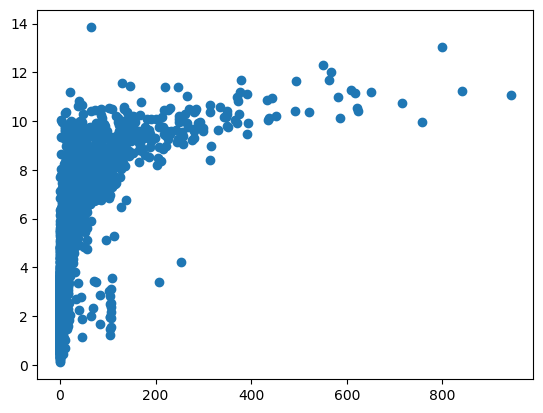

In [1547]:
common = data1.index & RNA_matrix_before_pred.index
plt.scatter( data1.loc[common].mean(axis=1),  RNA_matrix_before_pred.loc[common].mean(axis=1))

## merge 20 datasets

In [3]:
dict_dataset = {}

##############################################################################
##############################################################################
mykey = "colon_86_2014_labelfree"
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/colon/RNA_matrix_14959row86col.txt"
dict_dataset[mykey]["RNA"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/colon/protein_matrix_2244row86col.txt"
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

##############
mykey = "prostate_65_2019_labelfree"
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/prostate/RNA_matrix_21601row65col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/prostate/protein_matrix_3537row65col.txt" ###todo
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

##############
mykey = "lung_76_2020_labelfree"
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/lung/RNA_matrix_16597row76col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/lung/protein_matrix_2272row76col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

##############
mykey = "liver_62_2019_labelfree"
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/liver/RNA_matrix_14180row62col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/liver/protein_matrix_2354row62col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

############
mykey="brain_71_2017_labelfree"
dict_dataset[mykey] = {}

input="/media/eys/xwj/proteome/data/brain/RNA_matrix_14408row71col.txt"
RNA_matrix_1= pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
RNA_matrix_1.index = [ str(x).split(sep=".")[0] for x in RNA_matrix_1.index ]
dict_dataset[mykey]["RNA"] = RNA_matrix_1

input="/media/eys/xwj/proteome/data/brain/protein_matrix_4385row71col.txt"
protein_matrix_1= pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
protein_matrix_1.index = [ str(x).split(sep=".")[0] for x in protein_matrix_1.index ]
dict_dataset[mykey]["protein"] = protein_matrix_1
#################################################################################
#################################################################################
mykey = "liver_318_2019_tmt"
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/liver_val/RNA_matrix_12559row318col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/liver_val/protein_matrix_6472row318col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

################
mykey = "uterus_115_2020_tmt" ## Endometri
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/Endomet_val/RNA_matrix_16392row115col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/Endomet_val/protein_matrix_8900row115col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
###############
mykey = "lung_211_2020_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/lung_val/RNA_matrix_15257row211col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/lung_val/protein_matrix_7131row211col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
###############
mykey = "lung_89_2020_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/lung_2020_smoke/RNA_matrix_26595row89col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/lung_2020_smoke/protein_matrix_7005row89col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
###############
mykey = "colon_95_2019_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/colon_2019/RNA_matrix_12932row95col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/colon_2019/protein_matrix_4375row95col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

########################added 20210414
mykey = "renal_185_2019_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/renal_2019/RNA_matrix_14636row185col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/renal_2019/protein_matrix_7146row185col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

###############

mykey = "brain_108_2021_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/brain_2021/RNA_matrix_21542row108col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/brain_2021/protein_matrix_8825row108col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

###############
mykey = "pedbrain_188_2020_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/pedbrain_2020/RNA_matrix_18197row188col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/pedbrain_2020/protein_matrix_6425row188col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

###############
mykey = "headneck_151_2021_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/headneck_2021/RNA_matrix_16776row151col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/headneck_2021/protein_matrix_7511row151col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)

###############
mykey = "pancrea_140_2021_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/pancrea2021/RNA_matrix_17165row140col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/pancrea2021/protein_matrix_5748row140col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
print(mykey, dict_dataset[mykey]["RNA"].duplicated().value_counts())
###############
mykey = "lung_202_2021_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/lung2021/RNA_matrix_15587row202col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/lung2021/protein_matrix_8212row202col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
print(mykey, dict_dataset[mykey]["RNA"].duplicated().value_counts())

###############
mykey = "breast_122_2020_tmt" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/breast2020/RNA_matrix_10163row122col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/breast2020/protein_matrix_7581row122col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)


#################################################################################
#################################################################################
mykey = "breast_77_2016_itraq" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/breast_2016/RNA_matrix_14056row77col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/breast_2016/protein_matrix_6995row77col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
########################
mykey = "ovary_119_2016_itraq" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/ovary_2016/RNA_matrix_16697row119col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/ovary_2016/protein_matrix_4251row119col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
########################
mykey = "stomach_80_2019_itraq" 
dict_dataset[mykey] = {}
input="/media/eys/xwj/proteome/data/stomach_2019/RNA_matrix_15091row80col.txt"
dict_dataset[mykey]["RNA"] =  pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)
input="/media/eys/xwj/proteome/data/stomach_2019/protein_matrix_4900row80col.txt" 
dict_dataset[mykey]["protein"] = pd.read_csv(input, sep="\t", low_memory=False, header=0, index_col=0)


pancrea_140_2021_tmt False    17165
dtype: int64
lung_202_2021_tmt False    15587
dtype: int64


In [587]:
print((dict_dataset[mykey]["RNA"]> 0).all(axis=1).value_counts())
dict_dataset[mykey]["RNA"]

True    15091
dtype: int64


,112T,116T,118T,120T,124T,132T,136T,138T,140T,144T,...,5760T,60T,62T,64T,66T,68T,88T,90T,92T,96T
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,9.795,9.658,10.825,9.498,9.629,9.909,9.471,9.170,8.895,10.222,...,9.371,10.902,9.551,11.100,9.833,8.758,9.322,9.441,9.431,10.508
ENSG00000000419,9.396,9.821,9.624,9.588,9.688,9.391,9.466,9.914,9.280,9.220,...,9.433,9.762,9.441,10.463,9.885,9.580,9.708,9.272,9.951,9.905
ENSG00000000457,9.211,9.570,9.913,9.306,9.467,9.478,8.849,8.852,9.576,9.388,...,9.113,9.252,9.144,9.322,9.499,9.387,9.031,9.368,9.038,9.078
ENSG00000000460,7.857,8.461,9.299,8.584,8.282,8.801,8.338,8.243,8.770,8.163,...,7.691,8.026,8.280,9.095,8.010,8.522,8.226,8.039,7.954,8.155
ENSG00000000938,9.031,8.055,8.366,7.985,8.406,7.371,9.181,8.389,10.129,8.617,...,8.514,10.061,8.217,8.675,8.588,8.717,9.305,9.292,8.509,8.568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000272916,9.568,9.424,10.026,9.314,9.353,9.032,9.406,9.124,9.886,9.596,...,8.902,10.024,9.020,9.368,9.605,9.666,9.770,9.593,9.460,9.391
ENSG00000272962,8.921,9.161,9.797,9.598,9.585,8.282,8.854,7.929,7.593,8.225,...,7.906,8.935,7.355,8.772,9.328,7.656,9.197,8.103,9.024,7.146
ENSG00000273045,6.145,6.125,5.756,6.699,6.713,6.429,5.850,7.098,5.088,5.616,...,5.388,5.842,6.586,6.262,6.651,4.501,5.649,6.082,5.682,5.657


In [570]:
mykey ='pancrea_140_2021_tmt'
print((dict_dataset[mykey]["RNA"]).all(axis=1).value_counts())
print(dict_dataset[mykey]["RNA"].duplicated().value_counts())

True    17203
dtype: int64
False    17168
True        35
dtype: int64


In [4]:
datalist = list(dict_dataset.keys())
# mRNA-protein pair	detected RNAs	detected proteins
df_summary = pd.DataFrame(index = datalist, columns = ["common", "totalRNA", "totalprotein", "pearson","spearman"])

In [5]:
%%time
from scipy import stats

allgenes = set()
for mykey in datalist: 
    print(mykey)
    X = dict_dataset[mykey]["RNA"]
    Y = dict_dataset[mykey]["protein"]
    allgenes = allgenes | set(X.index) | set(Y.index)
    
# row_i, data_j = 0, 0
# df_input = pd.DataFrame(columns=["data_j", "name","gene", "pearson","spearman" ])
df_pearson    = pd.DataFrame(index = allgenes, columns=datalist)
df_spearman = pd.DataFrame(index = allgenes, columns=datalist)
print('1st pass')

colon_86_2014_labelfree
prostate_65_2019_labelfree
lung_76_2020_labelfree
liver_62_2019_labelfree
brain_71_2017_labelfree
liver_318_2019_tmt
uterus_115_2020_tmt
lung_211_2020_tmt
lung_89_2020_tmt
colon_95_2019_tmt
renal_185_2019_tmt
brain_108_2021_tmt
pedbrain_188_2020_tmt
headneck_151_2021_tmt
pancrea_140_2021_tmt
lung_202_2021_tmt
breast_122_2020_tmt
breast_77_2016_itraq
ovary_119_2016_itraq
stomach_80_2019_itraq
1st pass
CPU times: user 244 ms, sys: 37.8 ms, total: 281 ms
Wall time: 277 ms


In [6]:
# for mykey in ["colon_86_2014_labelfree"]:
for mykey in datalist: 
    print(mykey)
    X = dict_dataset[mykey]["RNA"].transform(lambda x: (x-x.mean())/x.std(), axis=1)#.round(3)
    Y = dict_dataset[mykey]["protein"].transform(lambda x: (x-x.mean())/x.std(), axis=1)#.round(3)
    
    
    df_summary.loc[mykey,"totalRNA"] = X.shape[0]
    df_summary.loc[mykey,"totalprotein"] = Y.shape[0]
    
    common_genes = (set(X.index) & set(Y.index))
    df_summary.loc[mykey,"common"] = len(common_genes)
    
    temp = pd.Series(index=common_genes,  data = [ stats.pearsonr(X.loc[g,:], Y.loc[g,:])[0] for g in common_genes ])
    df_summary.loc[mykey,"pearson"] = temp.median()
    df_pearson.loc[temp.index.values, mykey] = temp
    
    temp = pd.Series(index=common_genes,  data = [ stats.spearmanr(X.loc[g,:], Y.loc[g,:])[0] for g in common_genes ])
    df_summary.loc[mykey, "spearman"] = temp.median()
    df_spearman.loc[temp.index.values, mykey] = temp
    
df_summary

colon_86_2014_labelfree
prostate_65_2019_labelfree
lung_76_2020_labelfree
liver_62_2019_labelfree
brain_71_2017_labelfree
liver_318_2019_tmt
uterus_115_2020_tmt
lung_211_2020_tmt
lung_89_2020_tmt
colon_95_2019_tmt
renal_185_2019_tmt
brain_108_2021_tmt
pedbrain_188_2020_tmt
headneck_151_2021_tmt
pancrea_140_2021_tmt
lung_202_2021_tmt
breast_122_2020_tmt
breast_77_2016_itraq
ovary_119_2016_itraq
stomach_80_2019_itraq


,common,totalRNA,totalprotein,pearson,spearman
colon_86_2014_labelfree,2113,14959,2244,0.229183,0.235372
prostate_65_2019_labelfree,3445,21601,3537,0.226986,0.224086
lung_76_2020_labelfree,2209,16597,2272,0.118115,0.104513
liver_62_2019_labelfree,2315,14180,2354,0.412494,0.386321
brain_71_2017_labelfree,4234,14408,4385,0.151748,0.152212
liver_318_2019_tmt,6195,12559,6472,0.448624,0.390871
uterus_115_2020_tmt,5038,16392,5177,0.522807,0.495767
lung_211_2020_tmt,6938,15257,7131,0.553341,0.500734
lung_89_2020_tmt,6467,26595,7005,0.172055,0.164934
colon_95_2019_tmt,4201,12932,4375,0.28984,0.28057


In [556]:
# file = "/media/eys/xwj/proteome/data/datasets_in_order,.txt"
# with open(file) as f:
#     datalist = f.read().splitlines()
# df_summary = df_summary.loc[datalist]
# df_spearman = df_spearman[datalist]
# df_pearson = df_pearson[datalist]

In [7]:
file = "/media/eys/xwj/proteome/data/datasets_in_order_shortname.txt"
datalist = pd.read_csv(file, sep="\t", header=0, low_memory=False)
df_summary = df_summary.reindex(datalist['Name'])
df_spearman = df_spearman[datalist['Name']]
df_pearson = df_pearson[datalist['Name']]
df_summary.loc[:, 'ShortName'] = datalist['ShortName'].values
df_summary

,common,totalRNA,totalprotein,pearson,spearman,ShortName
Name,,,,,,
colon_86_2014_labelfree,2113,14959,2244,0.229183,0.235372,CO_labelfree
brain_71_2017_labelfree,4234,14408,4385,0.151748,0.152212,BN_labelfree
prostate_65_2019_labelfree,3445,21601,3537,0.226986,0.224086,PR_labelfree
liver_62_2019_labelfree,2315,14180,2354,0.412494,0.386321,LV_labelfree
lung_76_2020_labelfree,2209,16597,2272,0.118115,0.104513,LU_labelfree
liver_318_2019_tmt,6195,12559,6472,0.448624,0.390871,LV_tmt
colon_95_2019_tmt,4201,12932,4375,0.28984,0.28057,CO_tmt
renal_185_2019_tmt,6933,14636,7146,0.510334,0.531295,RC_tmt
pedbrain_188_2020_tmt,6184,18197,6425,0.460076,0.428887,PBN_tmt


[ 86  71  65  62  76 318  95 185 188 122 115 211  89 202 151 140 108  77
 119  80] Name
colon_86_2014_labelfree       CO_labelfree
brain_71_2017_labelfree       BN_labelfree
prostate_65_2019_labelfree    PR_labelfree
liver_62_2019_labelfree       LV_labelfree
lung_76_2020_labelfree        LU_labelfree
liver_318_2019_tmt                  LV_tmt
colon_95_2019_tmt                   CO_tmt
renal_185_2019_tmt                  RC_tmt
pedbrain_188_2020_tmt              PBN_tmt
breast_122_2020_tmt                 BR_tmt
uterus_115_2020_tmt                 EC_tmt
lung_211_2020_tmt                 LU_1_tmt
lung_89_2020_tmt                  LU_2_tmt
lung_202_2021_tmt                 LU_3_tmt
headneck_151_2021_tmt               HN_tmt
pancrea_140_2021_tmt                PA_tmt
brain_108_2021_tmt                  BN_tmt
breast_77_2016_itraq              BR_itraq
ovary_119_2016_itraq              OV_itraq
stomach_80_2019_itraq             GC_itraq
Name: ShortName, dtype: object platform
labelfree   

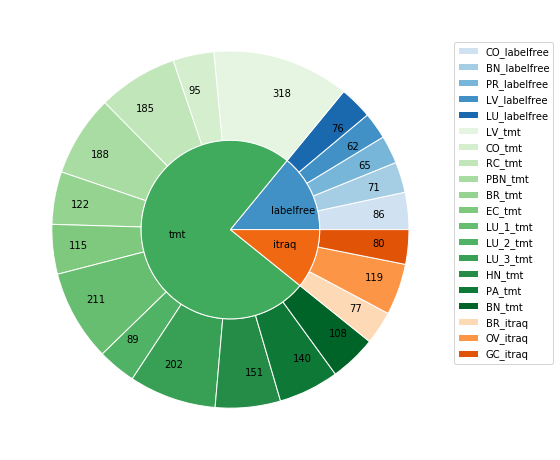

In [11]:
# df_summary.loc[:, "common"].plot.pie()

size = 0.5
###
data = df_summary.copy()
data.loc[:, "samples"] = [np.int(idx.split("_")[1]) for idx in data.index ]
data.loc[:, "platform"] = [idx.split("_")[-1] for idx in data.index ]

inner_value = data.groupby("platform", sort=False)["samples"].sum()
inner_label= ["labelfree", "tmt", "itraq"]
 
outer_value= data["samples"].values
outer_label  = data.ShortName

cmap = plt.get_cmap("Blues")
outer_colors = cmap([50, 90, 120, 160, 200])
inner_colors = cmap([160])

cmap = plt.get_cmap("Greens")
# outer_colors = np.vstack([outer_colors, cmap([50, 70, 90, 110, 130, 150, 170, 190, 210])])
outer_colors = np.vstack([outer_colors, cmap([30, 50, 70, 90, 105, 120, 135, 150, 170, 190, 210, 230])])
# start_color = 50
# end_color = 220
# step = (end_color - start_color)/12
# outer_colors = np.vstack([outer_colors, cmap( np.arange(start_color, end_color, step).tolist() )])
inner_colors = np.vstack([inner_colors, cmap([160])])

cmap = plt.get_cmap("Oranges")
outer_colors = np.vstack([outer_colors, cmap([50, 120,180])])
inner_colors = np.vstack([inner_colors, cmap([160])])
print(outer_value, outer_label, inner_value, inner_label)

fig, ax = plt.subplots(figsize=(8,10))
## version 1
ax.pie(outer_value, radius=1, colors=outer_colors, labels=outer_value, labeldistance=0.8,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(inner_value, radius=1-size, colors=inner_colors, labels = inner_label, labeldistance=0.5,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='')
plt.legend(loc=3, bbox_to_anchor=(1, 0.2), borderaxespad=0, labels= list(outer_label))

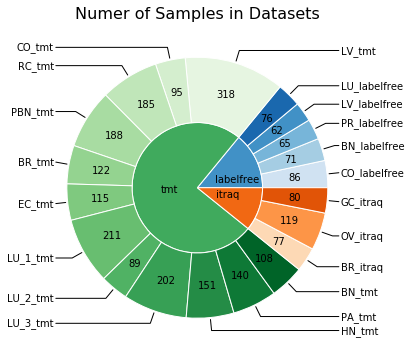

In [12]:
## version 2
size = 0.5
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(inner_value, radius=1-size, colors=inner_colors, labels = inner_label, labeldistance=0.3, #0.5
       wedgeprops=dict(width=size, edgecolor='w'))
# for t in texts:
#       t.set_horizontalalignment('center')
        
wedges, texts = ax.pie(outer_value, radius=1, colors=outer_colors, labels=outer_value, labeldistance=0.75,
       wedgeprops=dict(width=size, edgecolor='w'))
for t in texts:
      t.set_horizontalalignment('center')

bbox_props = dict(boxstyle="square,pad=0", fc="w", ec="k", lw=0)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1

    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(outer_label[i], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),horizontalalignment=horizontalalignment,  fontsize=10, **kw)
    
ax.set_title("Numer of Samples in Datasets", fontsize=16)

# plt.show()
if True: 
    plt.savefig("/media/eys/xwj/proteome/data/figs/fig1a_pie.svg", format='svg', dpi=300, transparent=True, bbox_inches="tight")

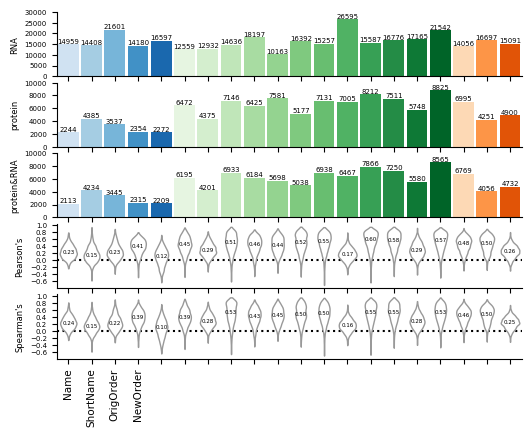

In [13]:
# Fixing random state for reproducibility
plt.rcdefaults()
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(6, 4.5))#(10,6))
font_size = 4#8
label_size = 5
fig.subplots_adjust(wspace=0, hspace=0.1)

x_pos = np.arange(len(datalist))

performance = df_summary["totalRNA"].values
ax[0].bar(x_pos, performance, align='center', color = outer_colors, width=0.9 )
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(datalist, fontsize=label_size)
# ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].set_ylabel('RNA', fontsize=label_size*1.2)
ax[0].set_yticks(range(0,31000,5000))
ax[0].tick_params(axis='y', labelsize= label_size , direction='out')
# Text on the top of each bar
for i in range(len(datalist)):
    ax[0].text(y = performance[i] , x = i, s = performance[i], size = label_size, rotation=0, ha='center', va='bottom')

performance = df_summary["totalprotein"].values
ax[1].bar(x_pos, performance, align='center', color = outer_colors, width=0.9)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(datalist, fontsize=label_size)
# ax[0].invert_yaxis()  # labels read top-to-bottom
ax[1].set_ylabel('protein', fontsize=label_size*1.2)
ax[1].set_yticks(range(0,11000, 2000))
ax[1].tick_params(axis='y', labelsize= label_size , direction='out')
# Text on the top of each bar
for i in range(len(datalist)):
    ax[1].text(y = performance[i] , x = i, s = performance[i], size = label_size, rotation=0, ha='center', va='bottom')
    
performance = df_summary["common"].values
ax[2].bar(x_pos, performance, align='center', color = outer_colors, width=0.9 )
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_xticks(x_pos)
ax[2].set_xticklabels(datalist, fontsize=label_size)
# ax[0].invert_yaxis()  # labels read top-to-bottom
ax[2].set_ylabel('protein&RNA', fontsize=label_size*1.2)
ax[2].set_yticks(range(0,11000, 2000))
ax[2].tick_params(axis='y', labelsize= label_size , direction='out')
# Text on the top of each bar
for i in range(len(datalist)):
    ax[2].text(y = performance[i] , x = i, s = performance[i], size = label_size, rotation=0, ha='center', va='bottom')
    
sns.violinplot(data=df_pearson,  color="w", scale= 'area', linewidth= 1, cut=0, inner=None,  orient="v", ax =ax[3]) # inner="quartile", saturation=1
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].set_yticks(np.arange(-0.6, 1.2, 0.2)) 
ax[3].set_ylabel("Pearson's", fontsize=label_size*1.2)
ax[3].tick_params(axis='y', labelsize= label_size , direction='out')
ax[3].axhline(y=0, color='black', linestyle='dotted', zorder =0)
performance = df_summary["pearson"].values
for i in range(len(datalist)):
    ax[3].text(y = performance[i], x = i, s = "%.2f" % (performance[i]), size = font_size, rotation=0,  horizontalalignment='center', va='center')

sns.violinplot(data=df_spearman,  color="w", scale= 'area', linewidth= 1, cut=0, inner=None,  orient="v", ax =ax[4]) # inner="quartile", saturation=1
ax[4].spines['right'].set_visible(False)
ax[4].spines['top'].set_visible(False)
ax[4].set_yticks(np.arange(-0.6, 1.2, 0.2)) 
ax[4].set_ylabel("Spearman's", fontsize=label_size*1.2)
ax[4].tick_params(axis='y', labelsize= label_size , direction='out')
ax[4].axhline(y=0, color='black', linestyle='dotted', zorder =0)
performance = df_summary["spearman"].values
for i in range(len(datalist)):
    ax[4].text(y = performance[i], x = i, s = "%.2f" % (performance[i]), size = font_size, rotation=0, horizontalalignment='center', va='center')
ax[4].set_xticklabels(datalist, fontsize=label_size*1.5, rotation=90)
# plt.show()
if False: 
    plt.savefig("/media/eys/xwj/proteome/data/figs/fig1b_bar_violin.svg", format='svg', transparent=True, bbox_inches="tight")

In [14]:
df_summary.loc[:, "tissue"] = [np.str(idx.split("_")[0]) for idx in df_summary.index ]
df_summary.loc[:, "samples"] = [np.int(idx.split("_")[1]) for idx in df_summary.index ]
df_summary

,common,totalRNA,totalprotein,pearson,spearman,ShortName,tissue,samples
Name,,,,,,,,
colon_86_2014_labelfree,2113,14959,2244,0.229183,0.235372,CO_labelfree,colon,86
brain_71_2017_labelfree,4234,14408,4385,0.151748,0.152212,BN_labelfree,brain,71
prostate_65_2019_labelfree,3445,21601,3537,0.226986,0.224086,PR_labelfree,prostate,65
liver_62_2019_labelfree,2315,14180,2354,0.412494,0.386321,LV_labelfree,liver,62
lung_76_2020_labelfree,2209,16597,2272,0.118115,0.104513,LU_labelfree,lung,76
liver_318_2019_tmt,6195,12559,6472,0.448624,0.390871,LV_tmt,liver,318
colon_95_2019_tmt,4201,12932,4375,0.28984,0.28057,CO_tmt,colon,95
renal_185_2019_tmt,6933,14636,7146,0.510334,0.531295,RC_tmt,renal,185
pedbrain_188_2020_tmt,6184,18197,6425,0.460076,0.428887,PBN_tmt,pedbrain,188


### output dict_matrix y-pred, time

In [589]:
file = '/media/eys/xwj/proteome/data/20210926_dict_matrix_20dataset.pkl' 

if False:
    import pickle
    # Saving the objects:
    with open(file, 'wb') as f:    
        pickle.dump( [dict_dataset, df_summary ],  f)